In [71]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import sys
sys.path.append('../j2')

from quality import compute_overlap_array, bounding_box
from graphing import plot_volume
from util import remove_labels, overlay_images, calculate_stats
from skimage.measure import label
from IPython import display

In [105]:
annotation = io.imread('../data/annotation.tiff')
probmap_1 = io.imread('../data/probmap_span_1.tiff')
probmap_2 = io.imread('../data/probmap_span_2.tiff')

## Visual inspection of probability map

### First look at slicespan=1

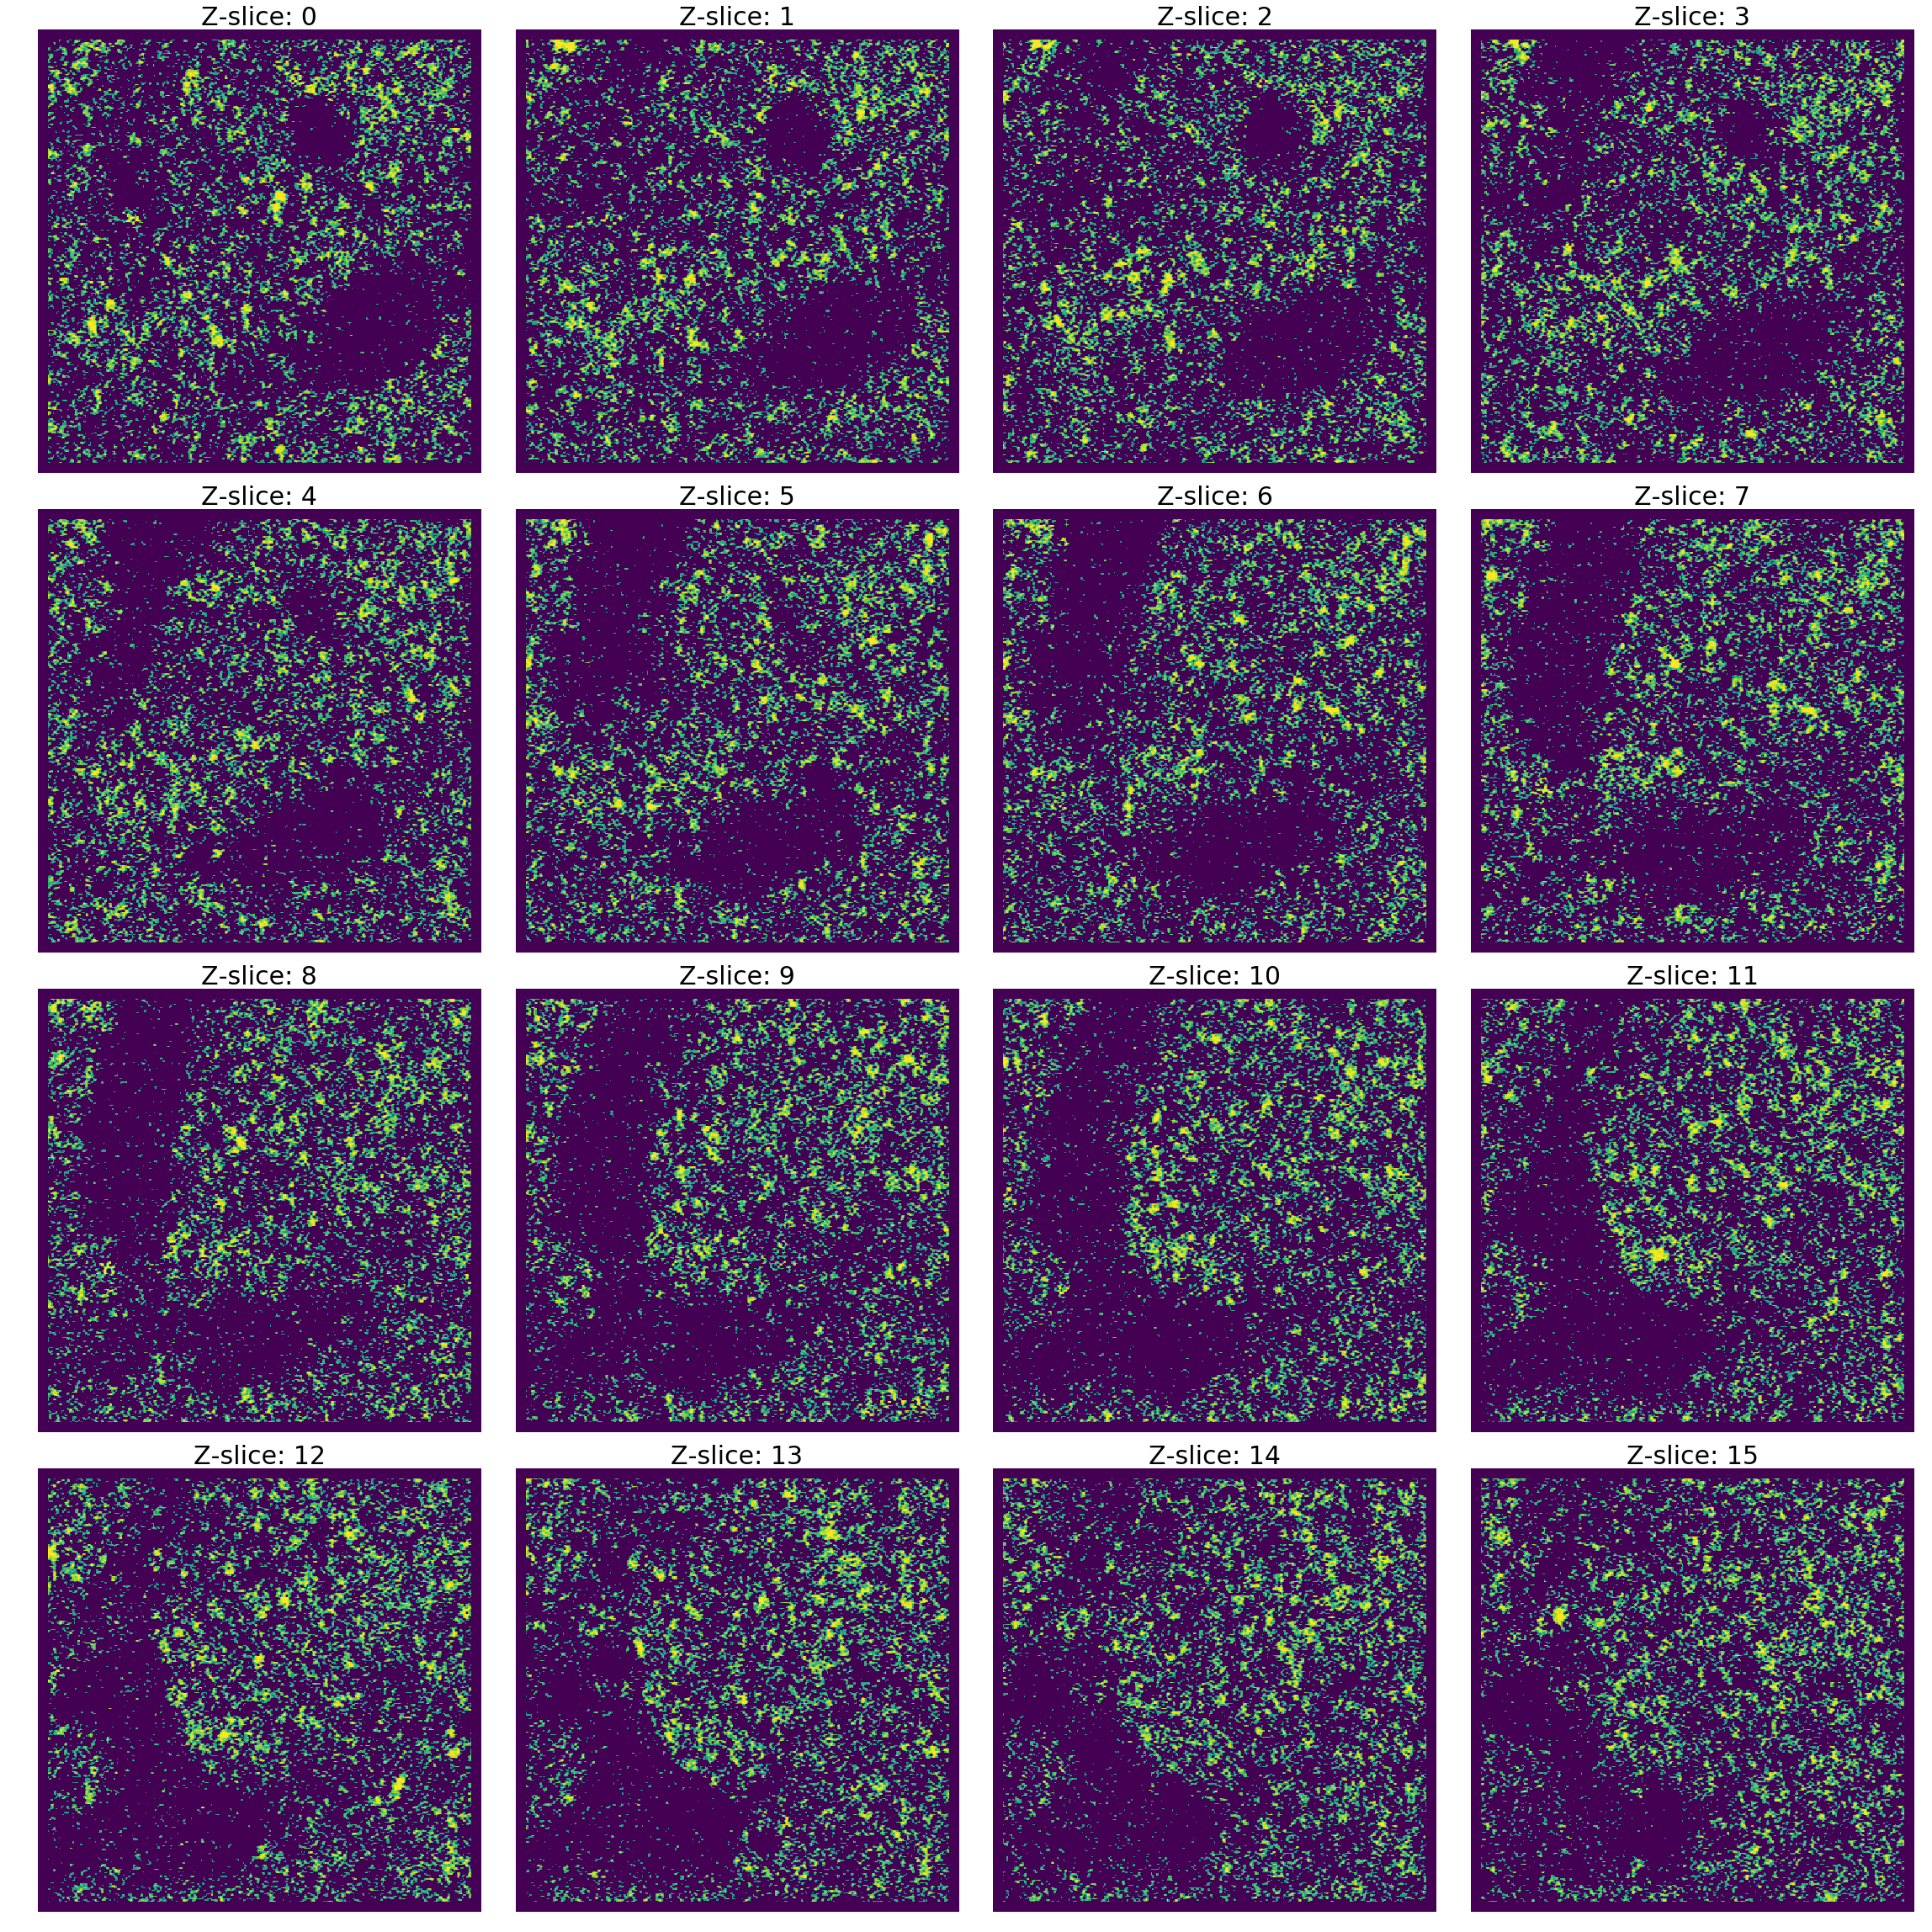

In [24]:
fig = plot_volume(probmap_1)
display.display(fig)

### Precision and recall values across a series of thresholds

In [38]:
predictions = []
thresholds = np.arange(0.01, 1.01, 0.01)
for threshold in thresholds:
    labels = label(probmap_1 >= threshold)
    predictions.append(len(np.unique(labels)))

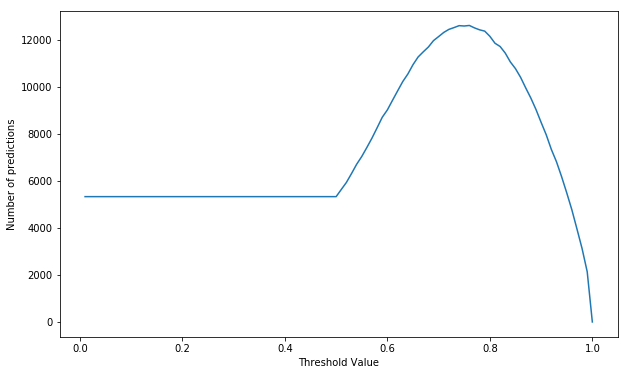

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(thresholds, predictions)
ax.set_xlabel('Threshold Value')
ax.set_ylabel('Number of predictions')
display.display(fig)

In [109]:
precisions = []
recalls = []
f1s = []
thresholds = np.arange(0.5, 1.0, 0.01)

for threshold in thresholds:
    labels = label(probmap_1 >= threshold)
    overlaps = compute_overlap_array(labels, annotation)
    precision, recall, f1 = calculate_stats(overlaps)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

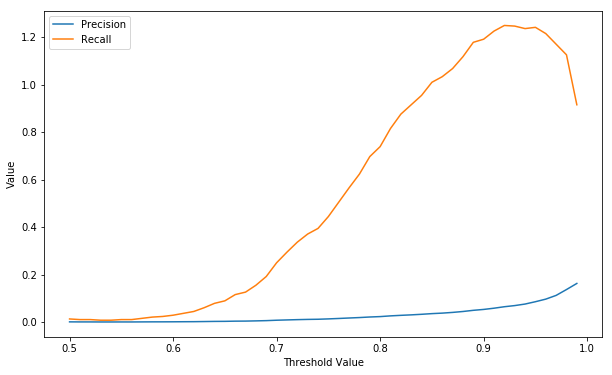

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(thresholds, precisions, label='Precision')
ax.plot(thresholds, recalls, label='Recall')
ax.set_xlabel('Threshold Value')
ax.set_ylabel('Value')
ax.legend()
display.display(fig)

In [70]:
plt.close('all')

## Visual inspection of overlay images at different thresholds

#### Look at every 0.05 threshold points from 0.5 to 1

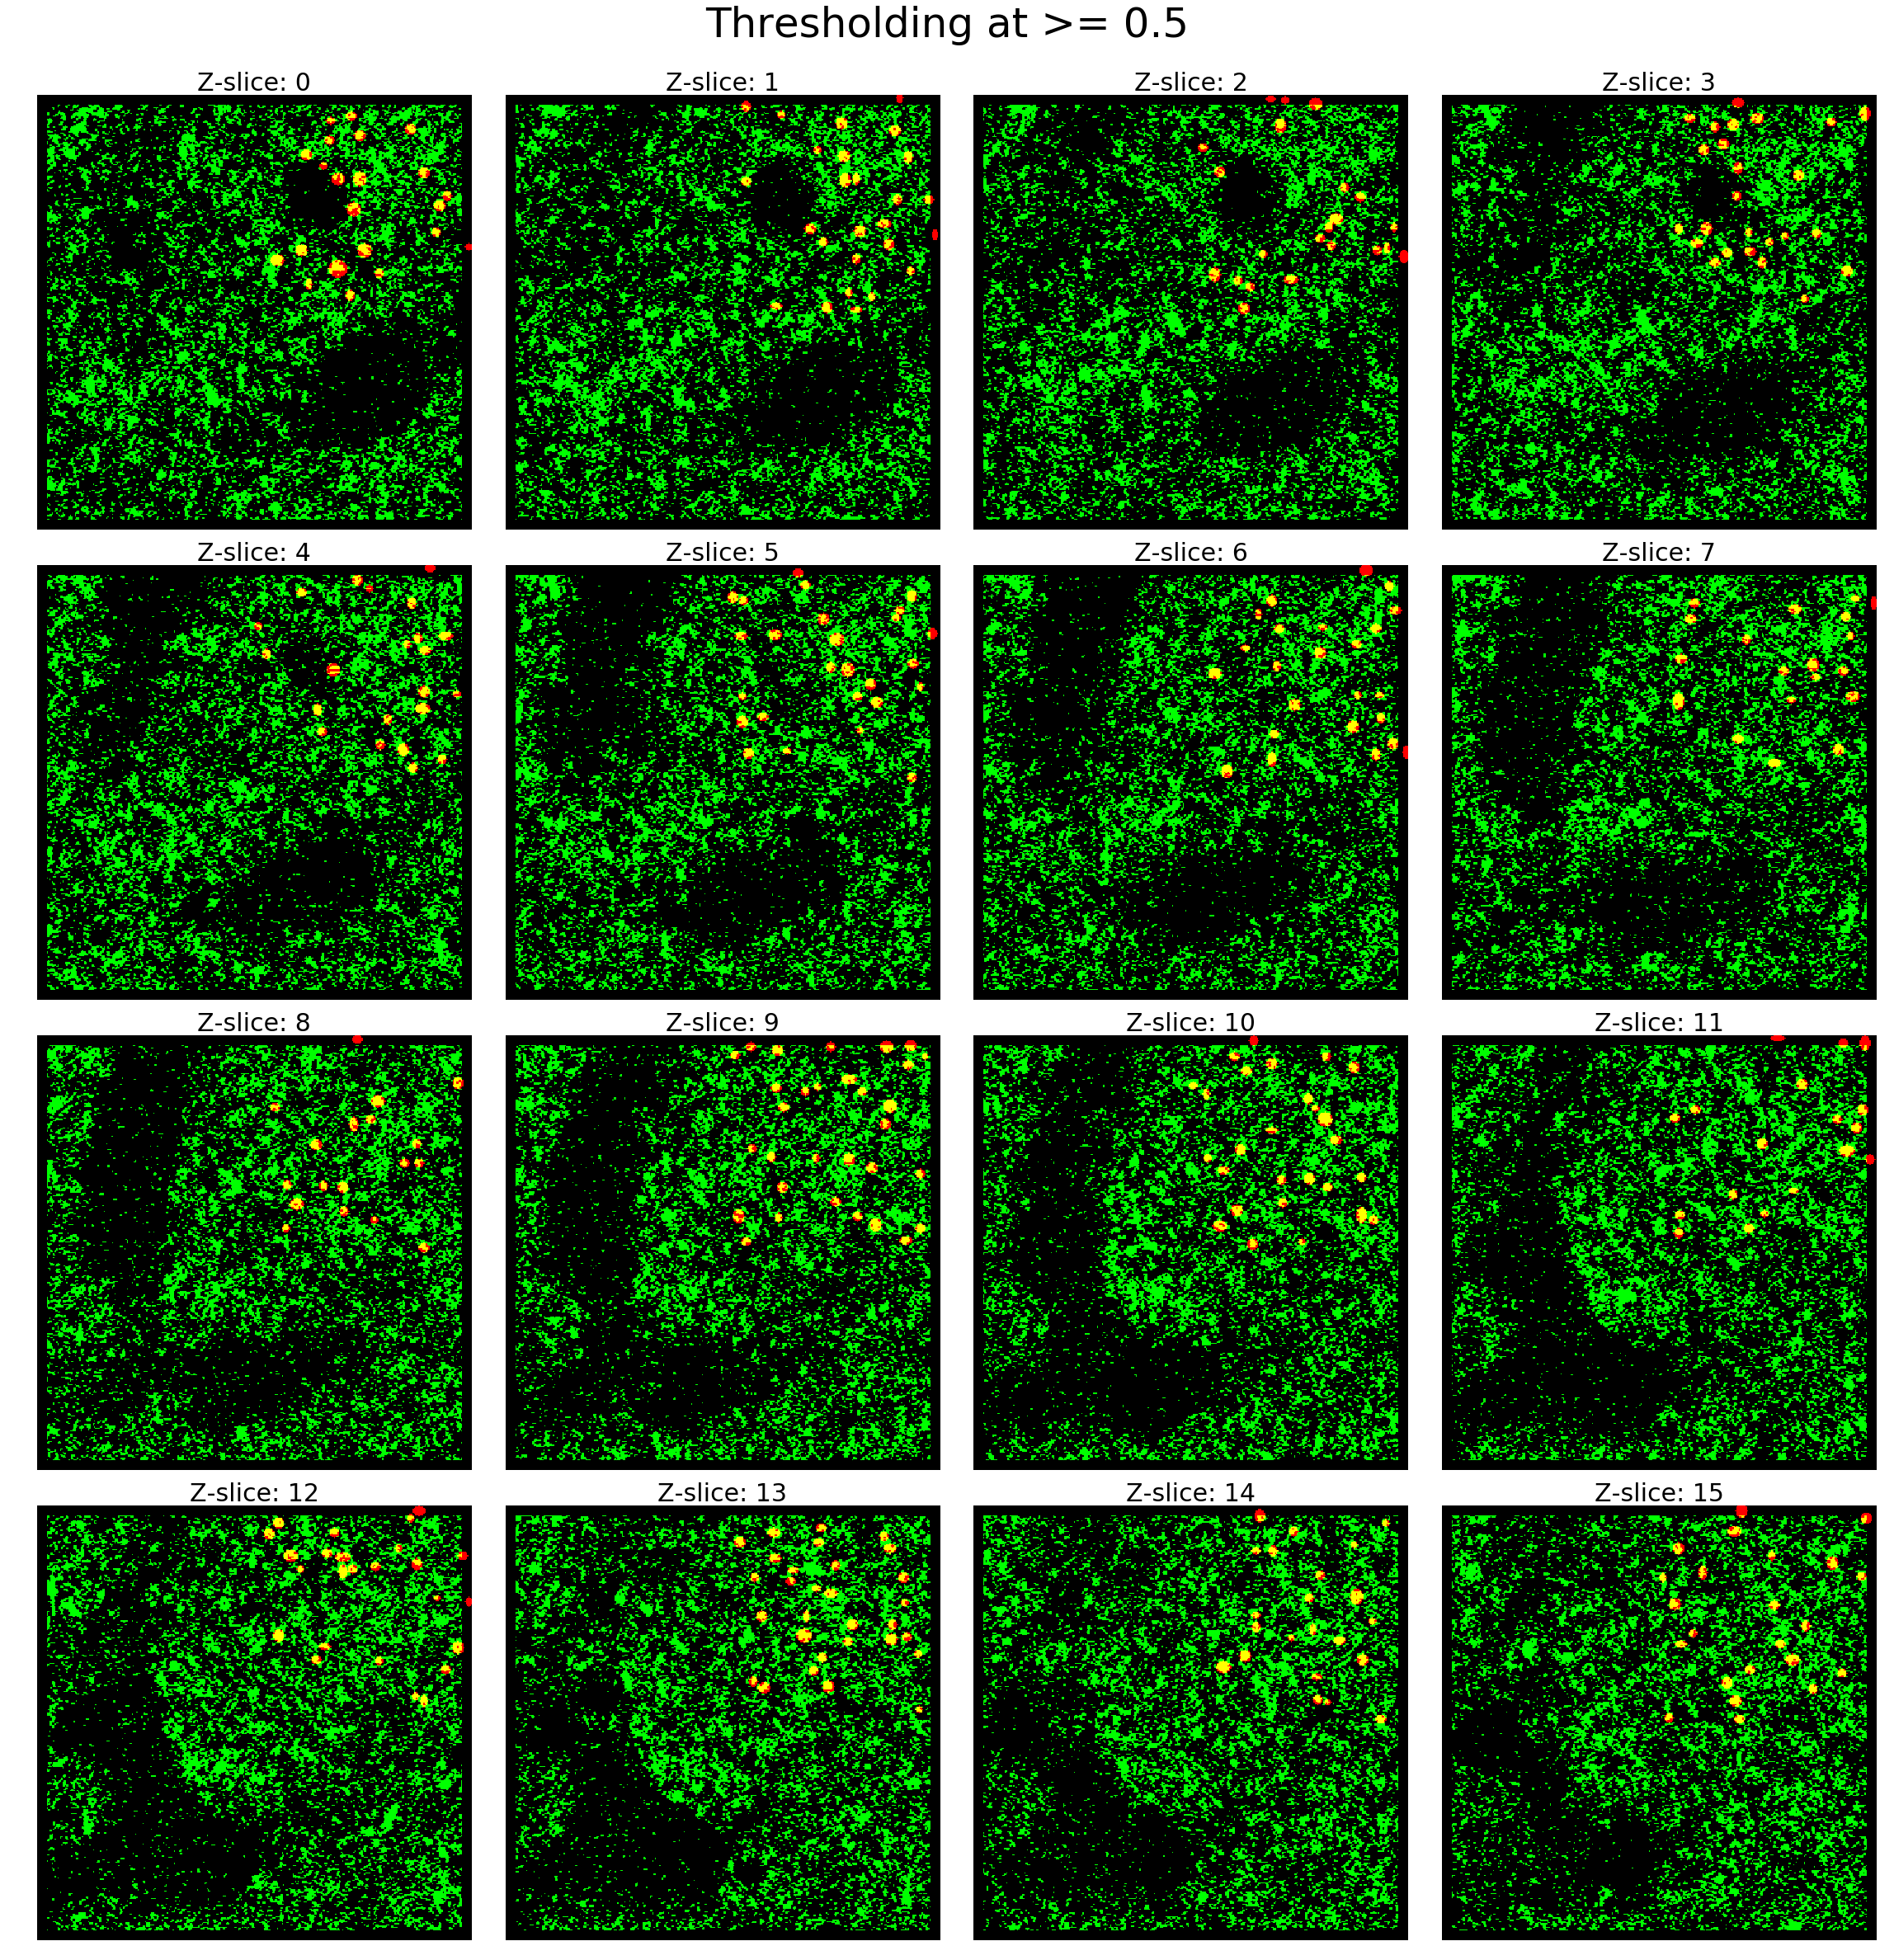

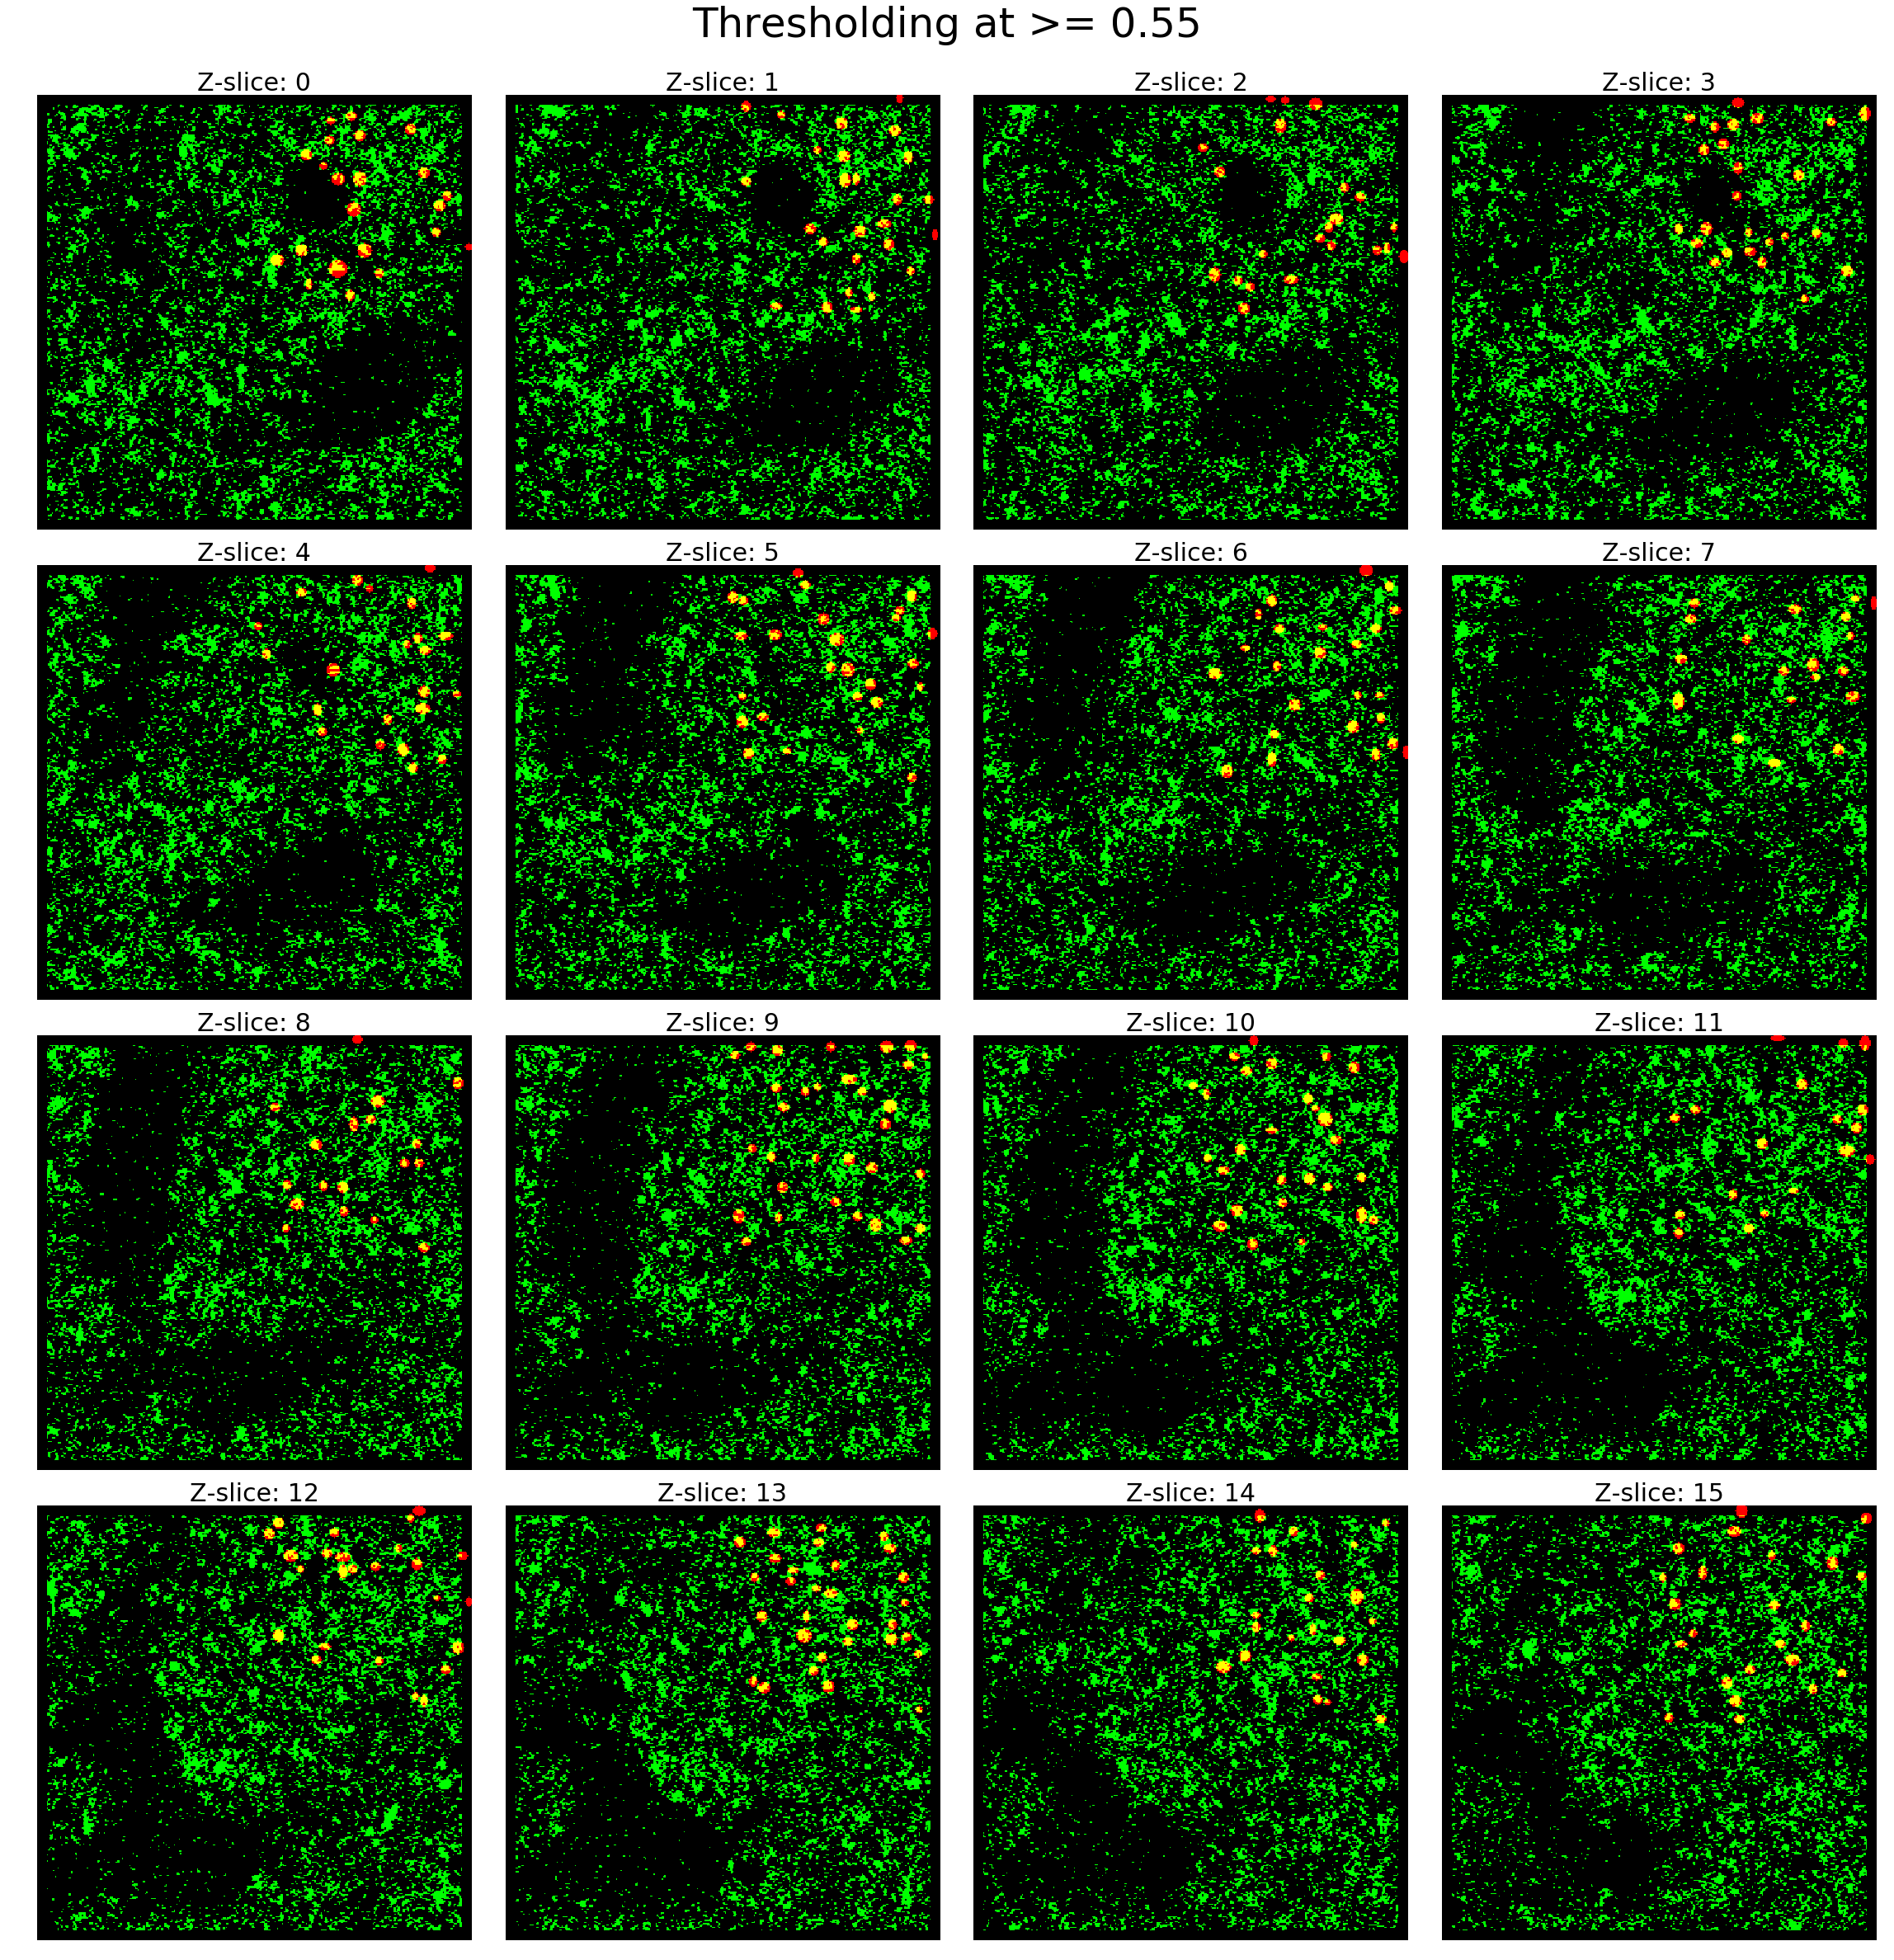

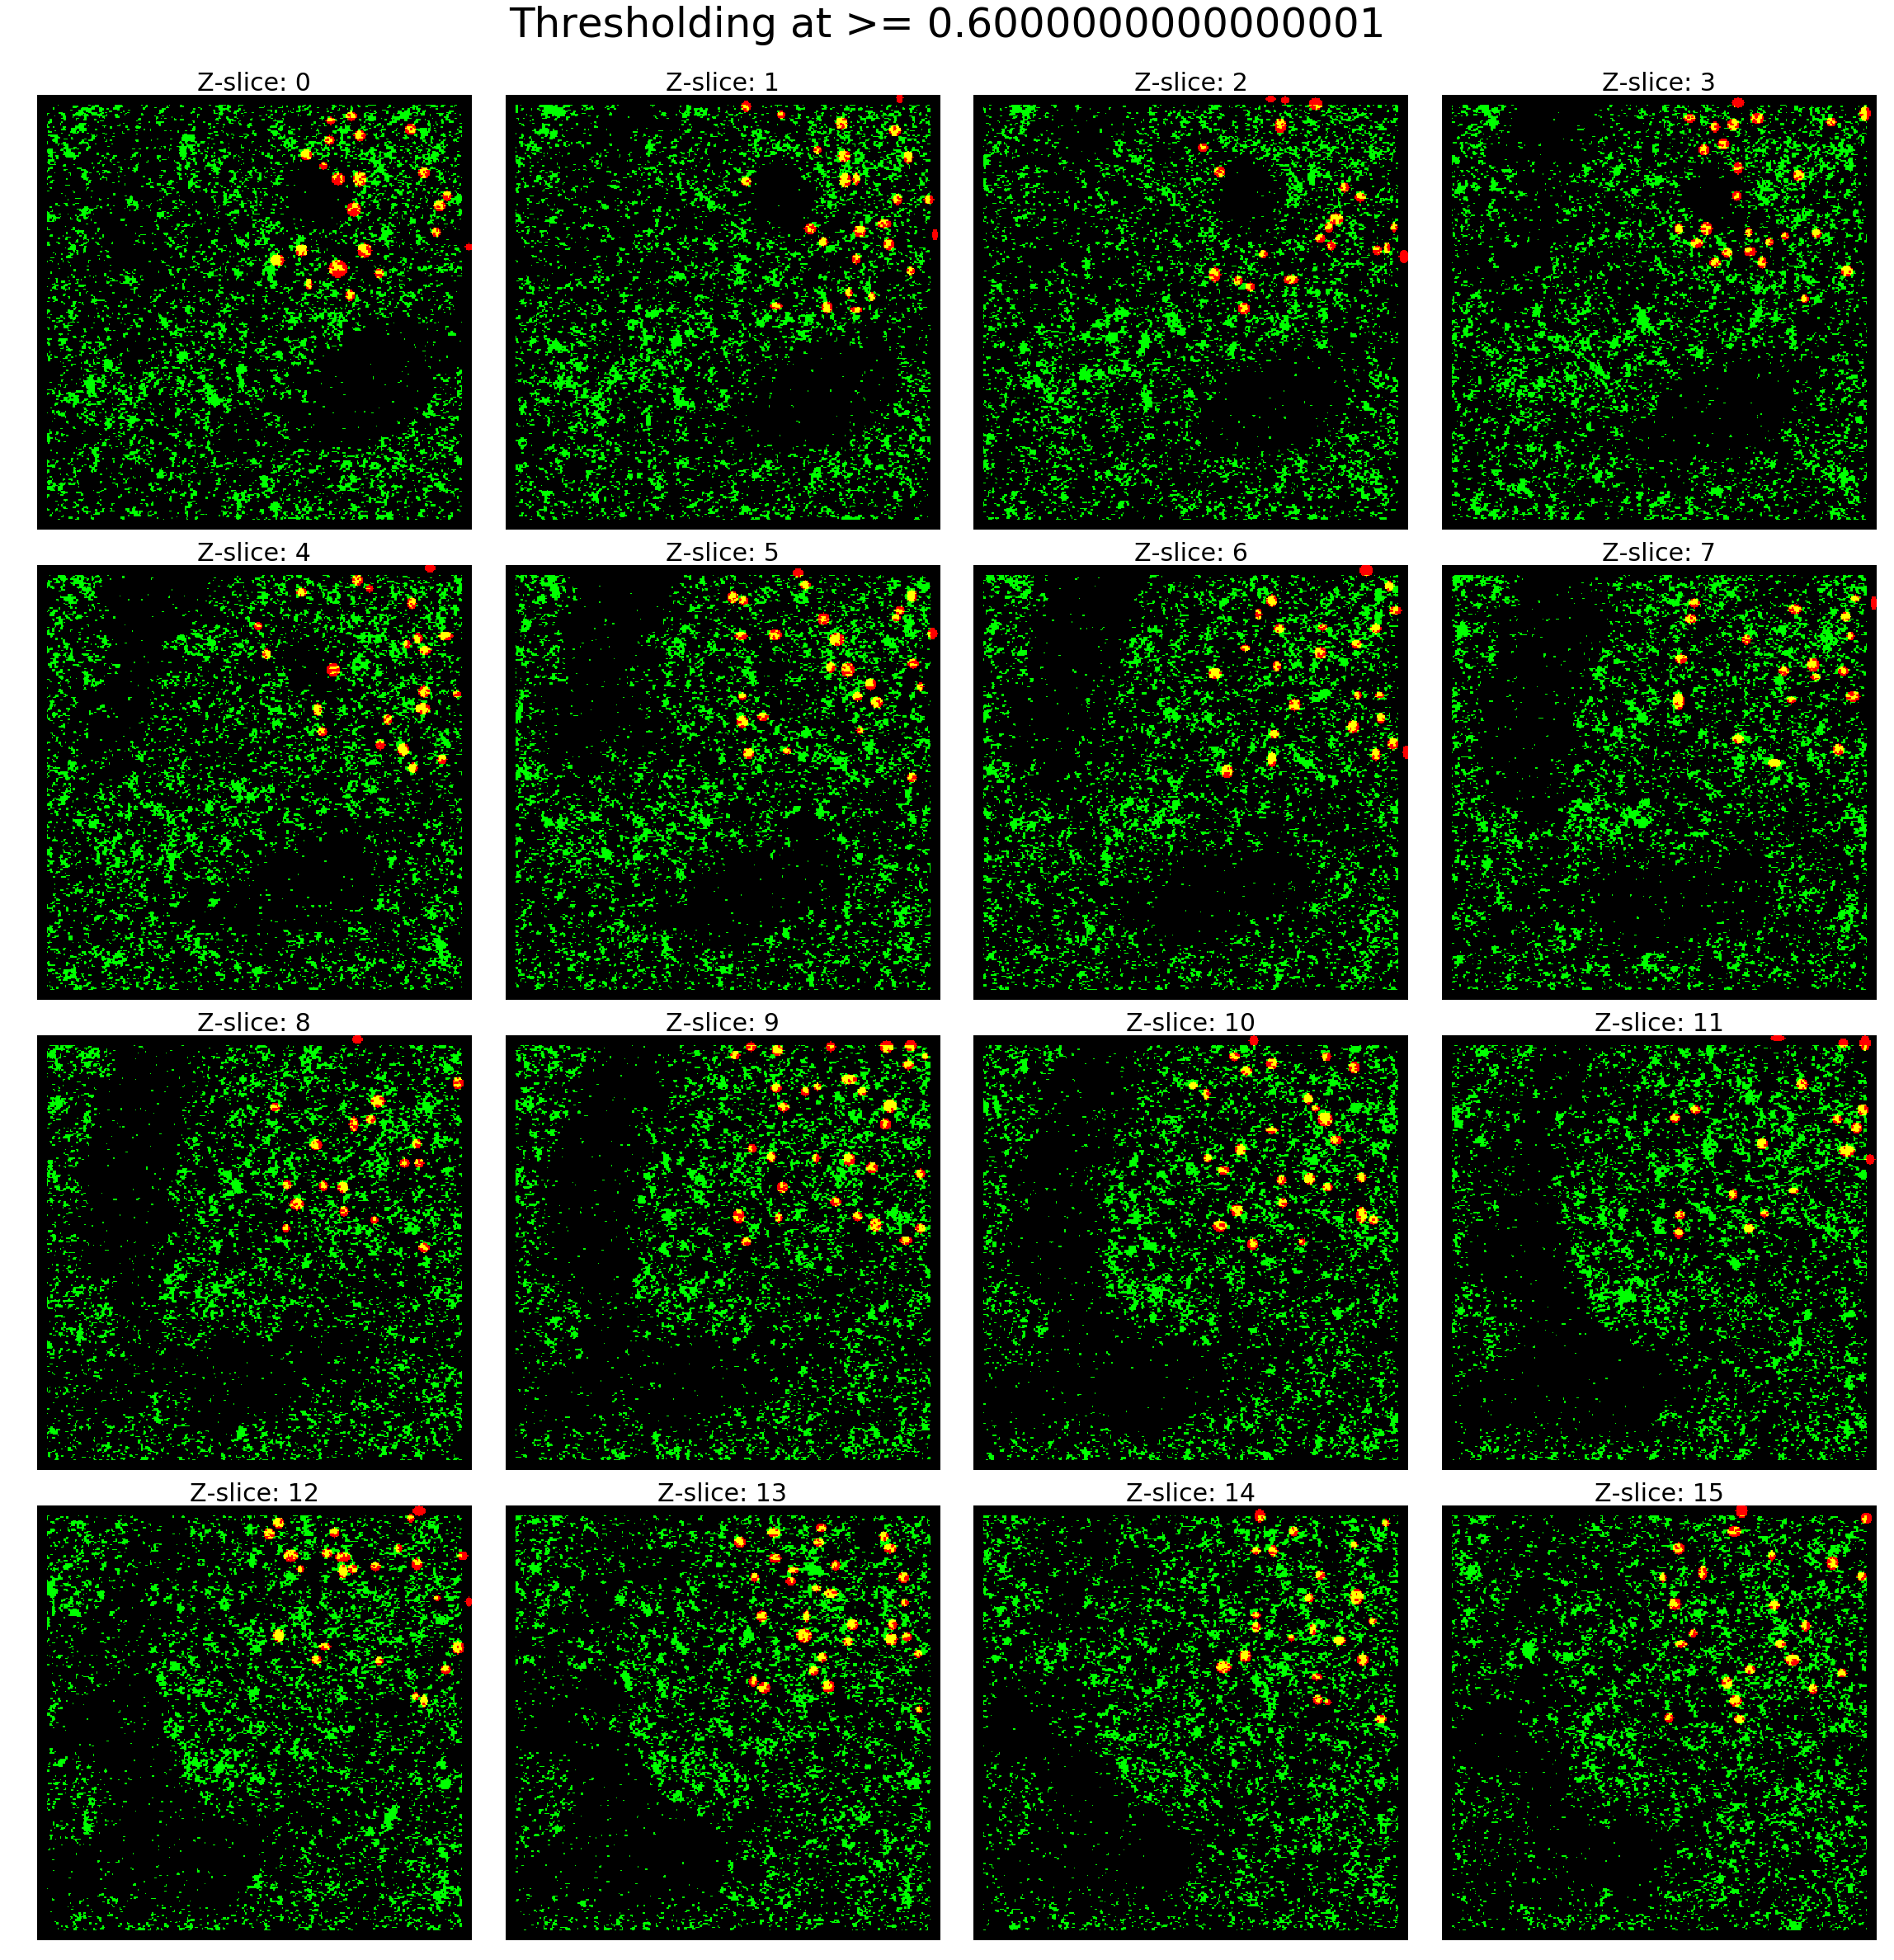

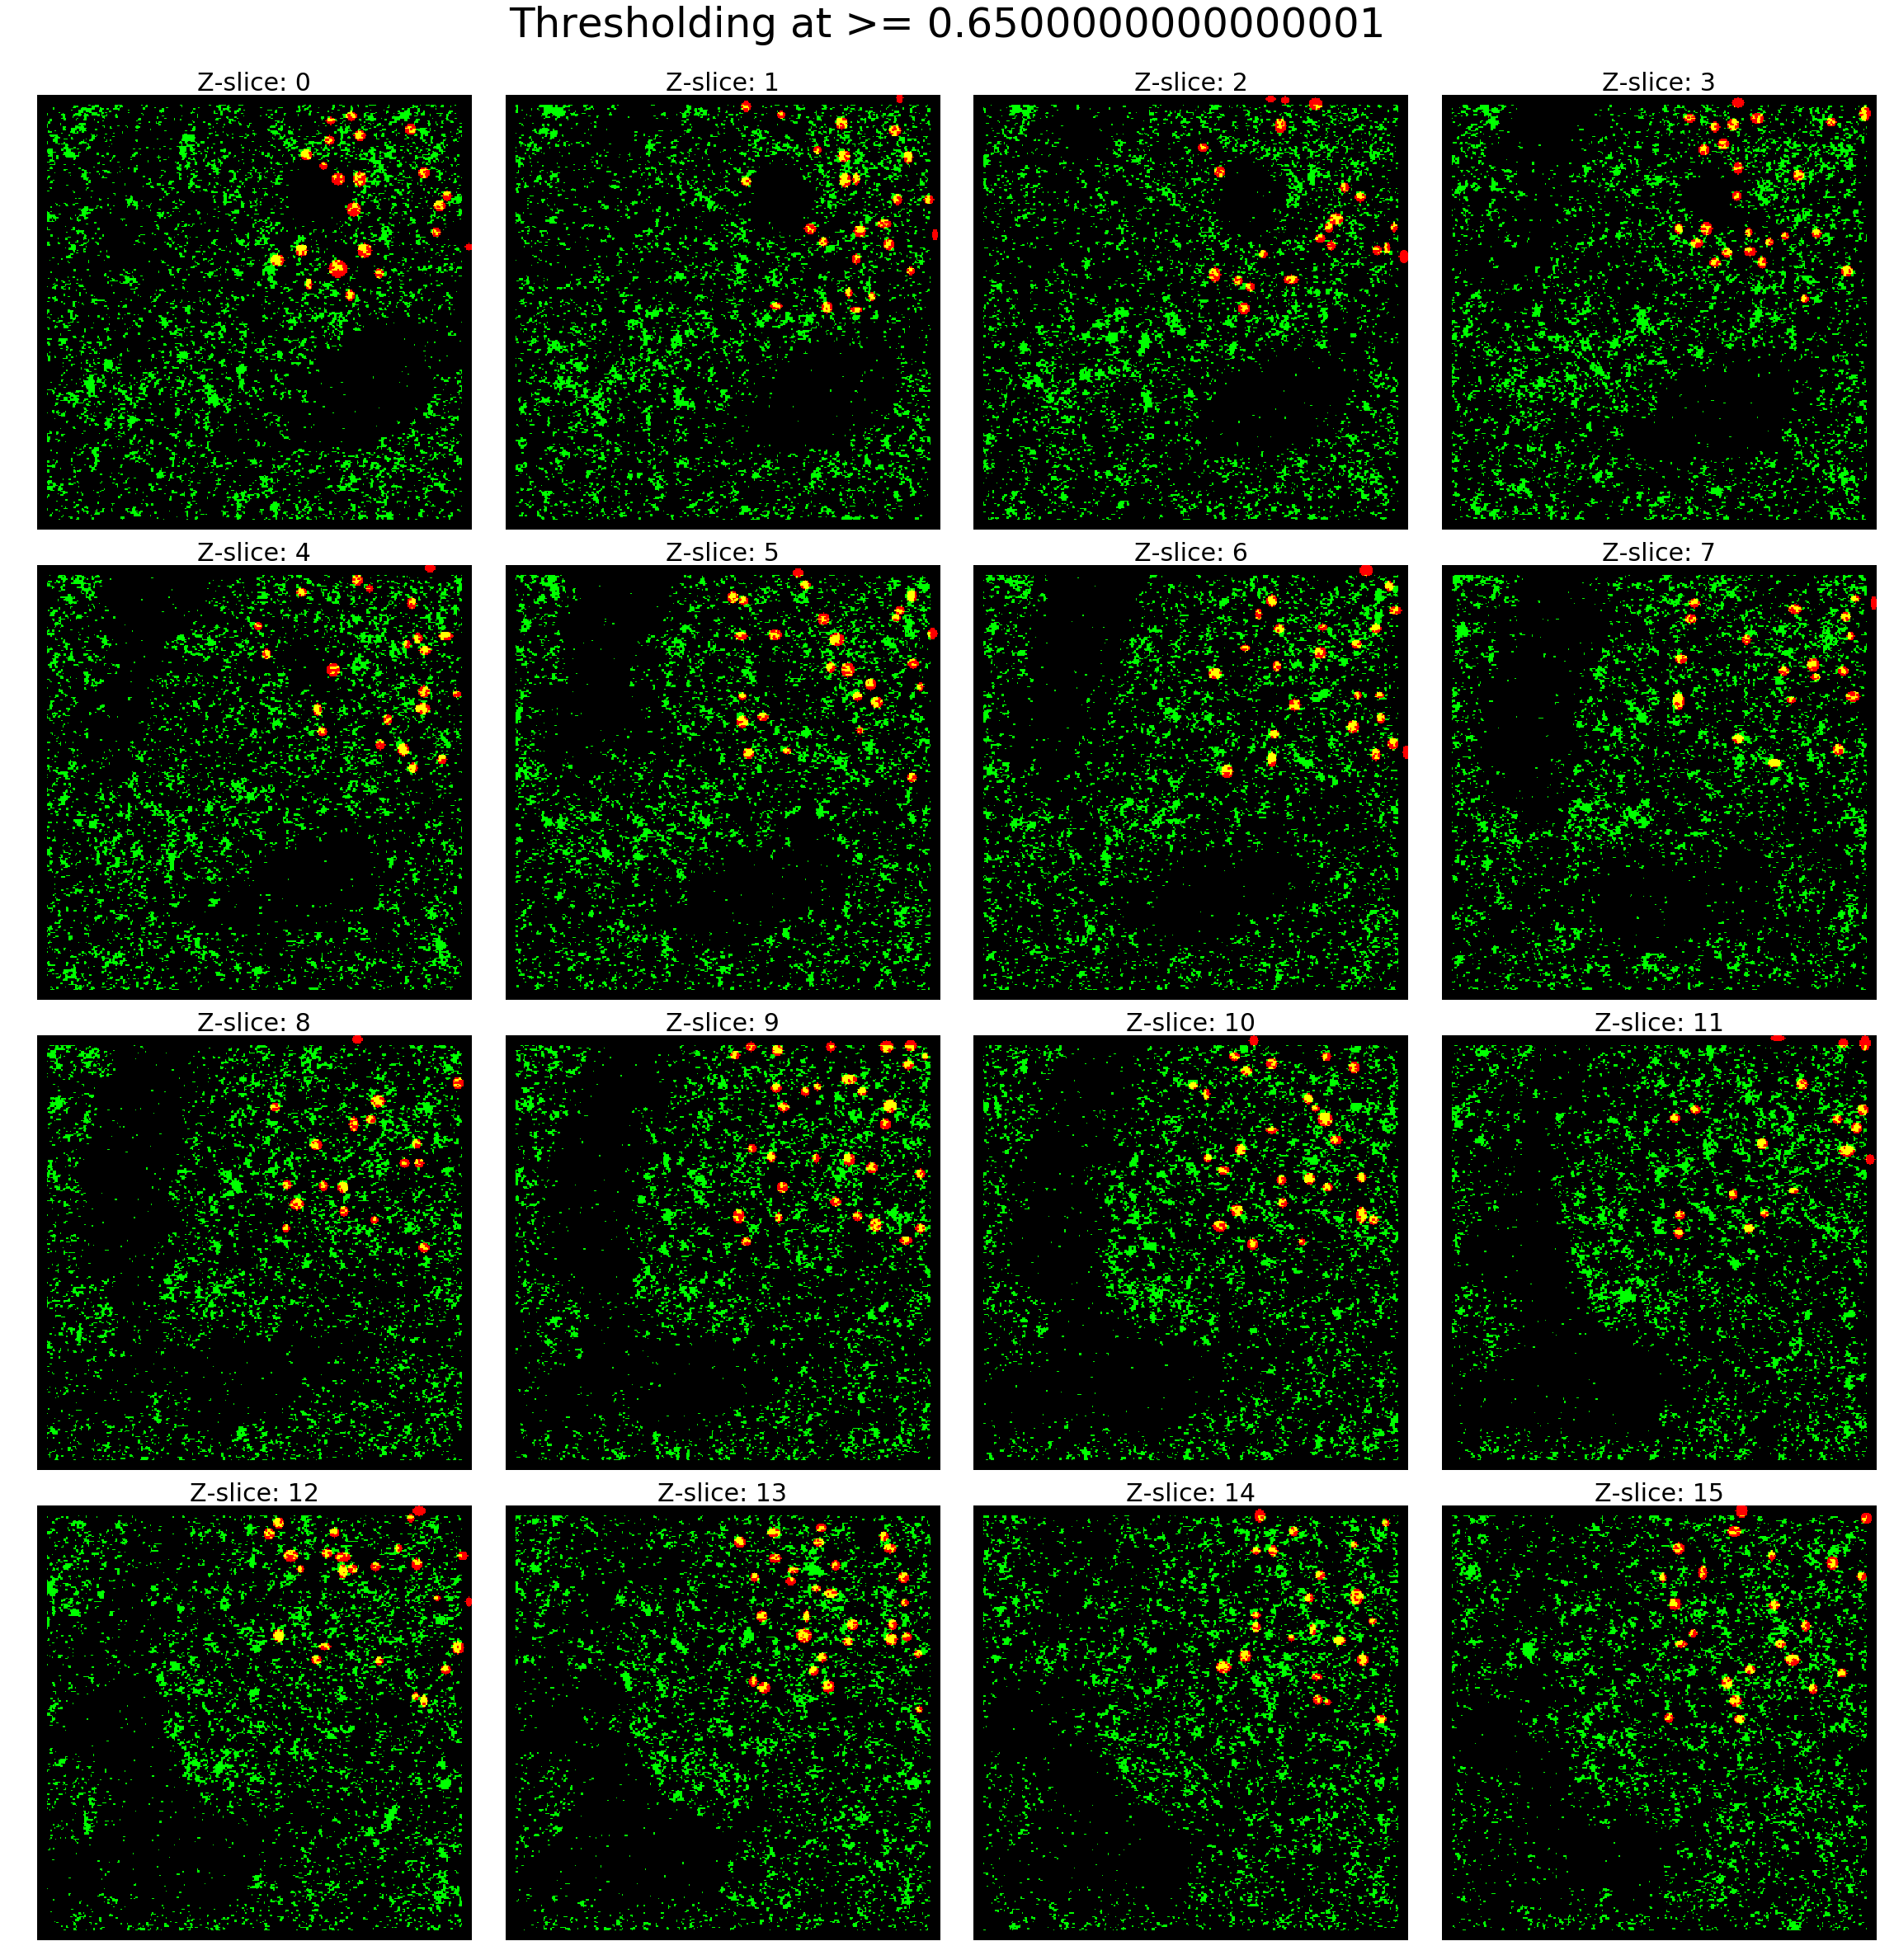

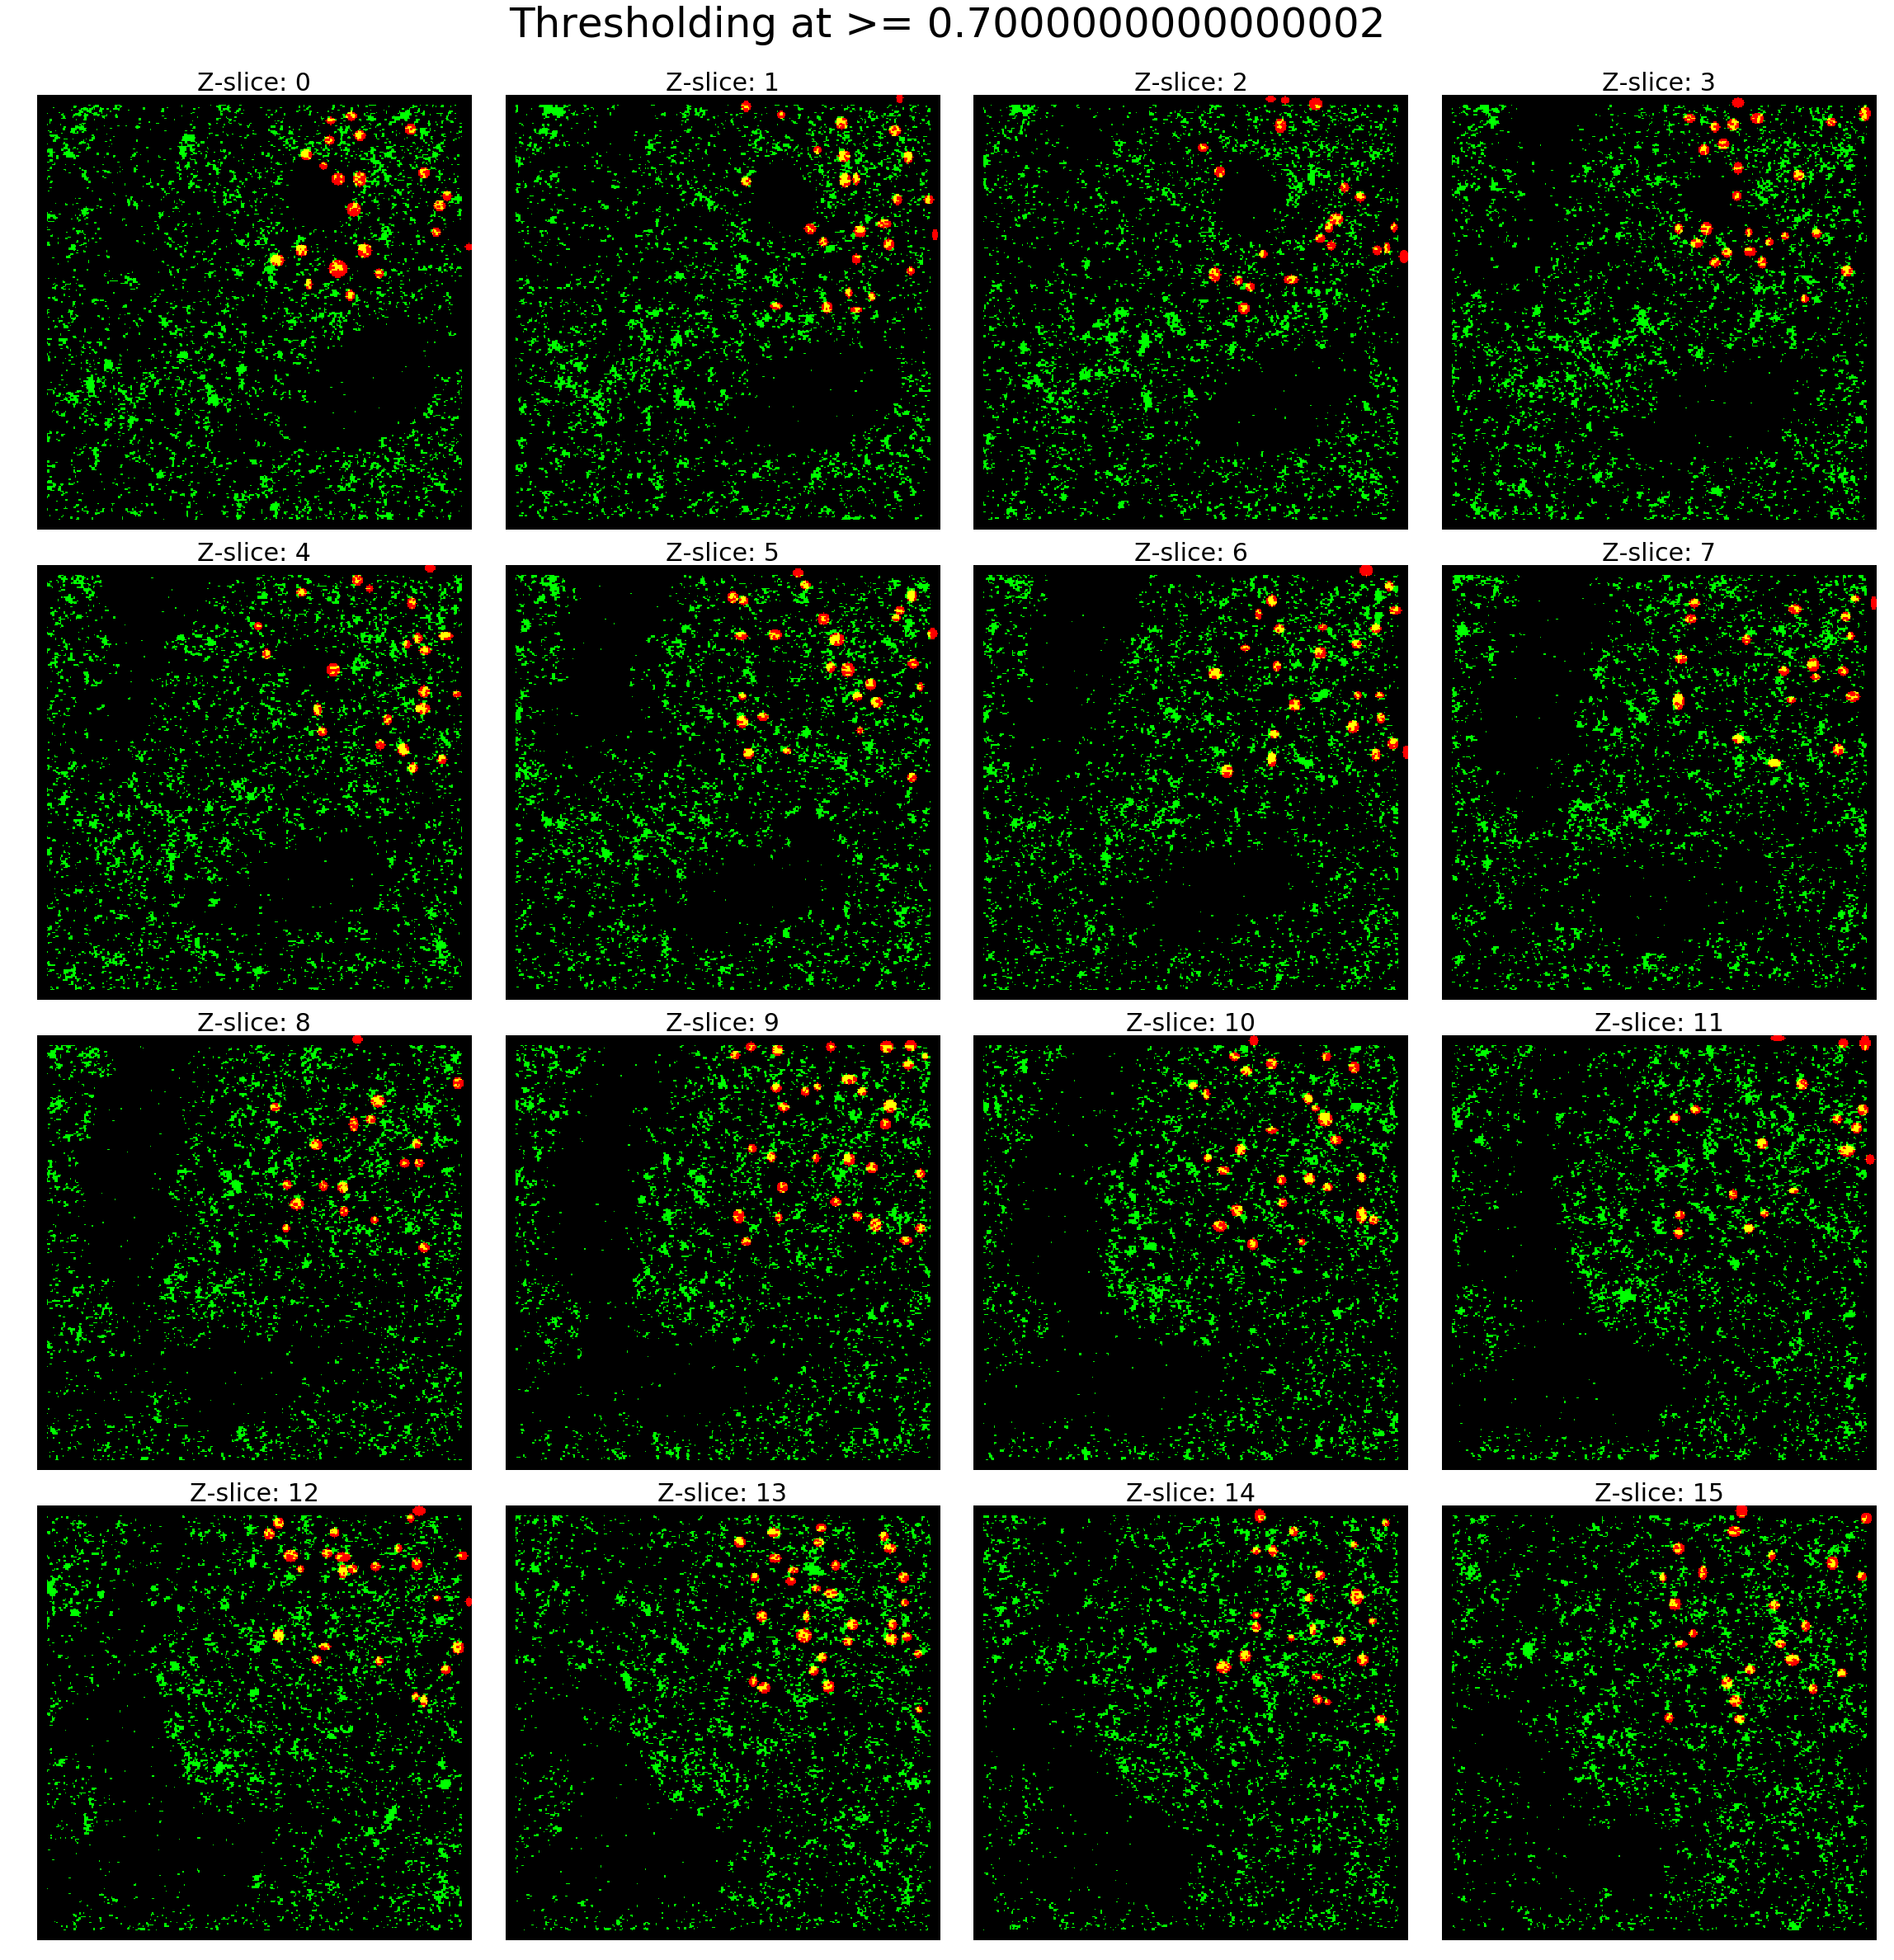

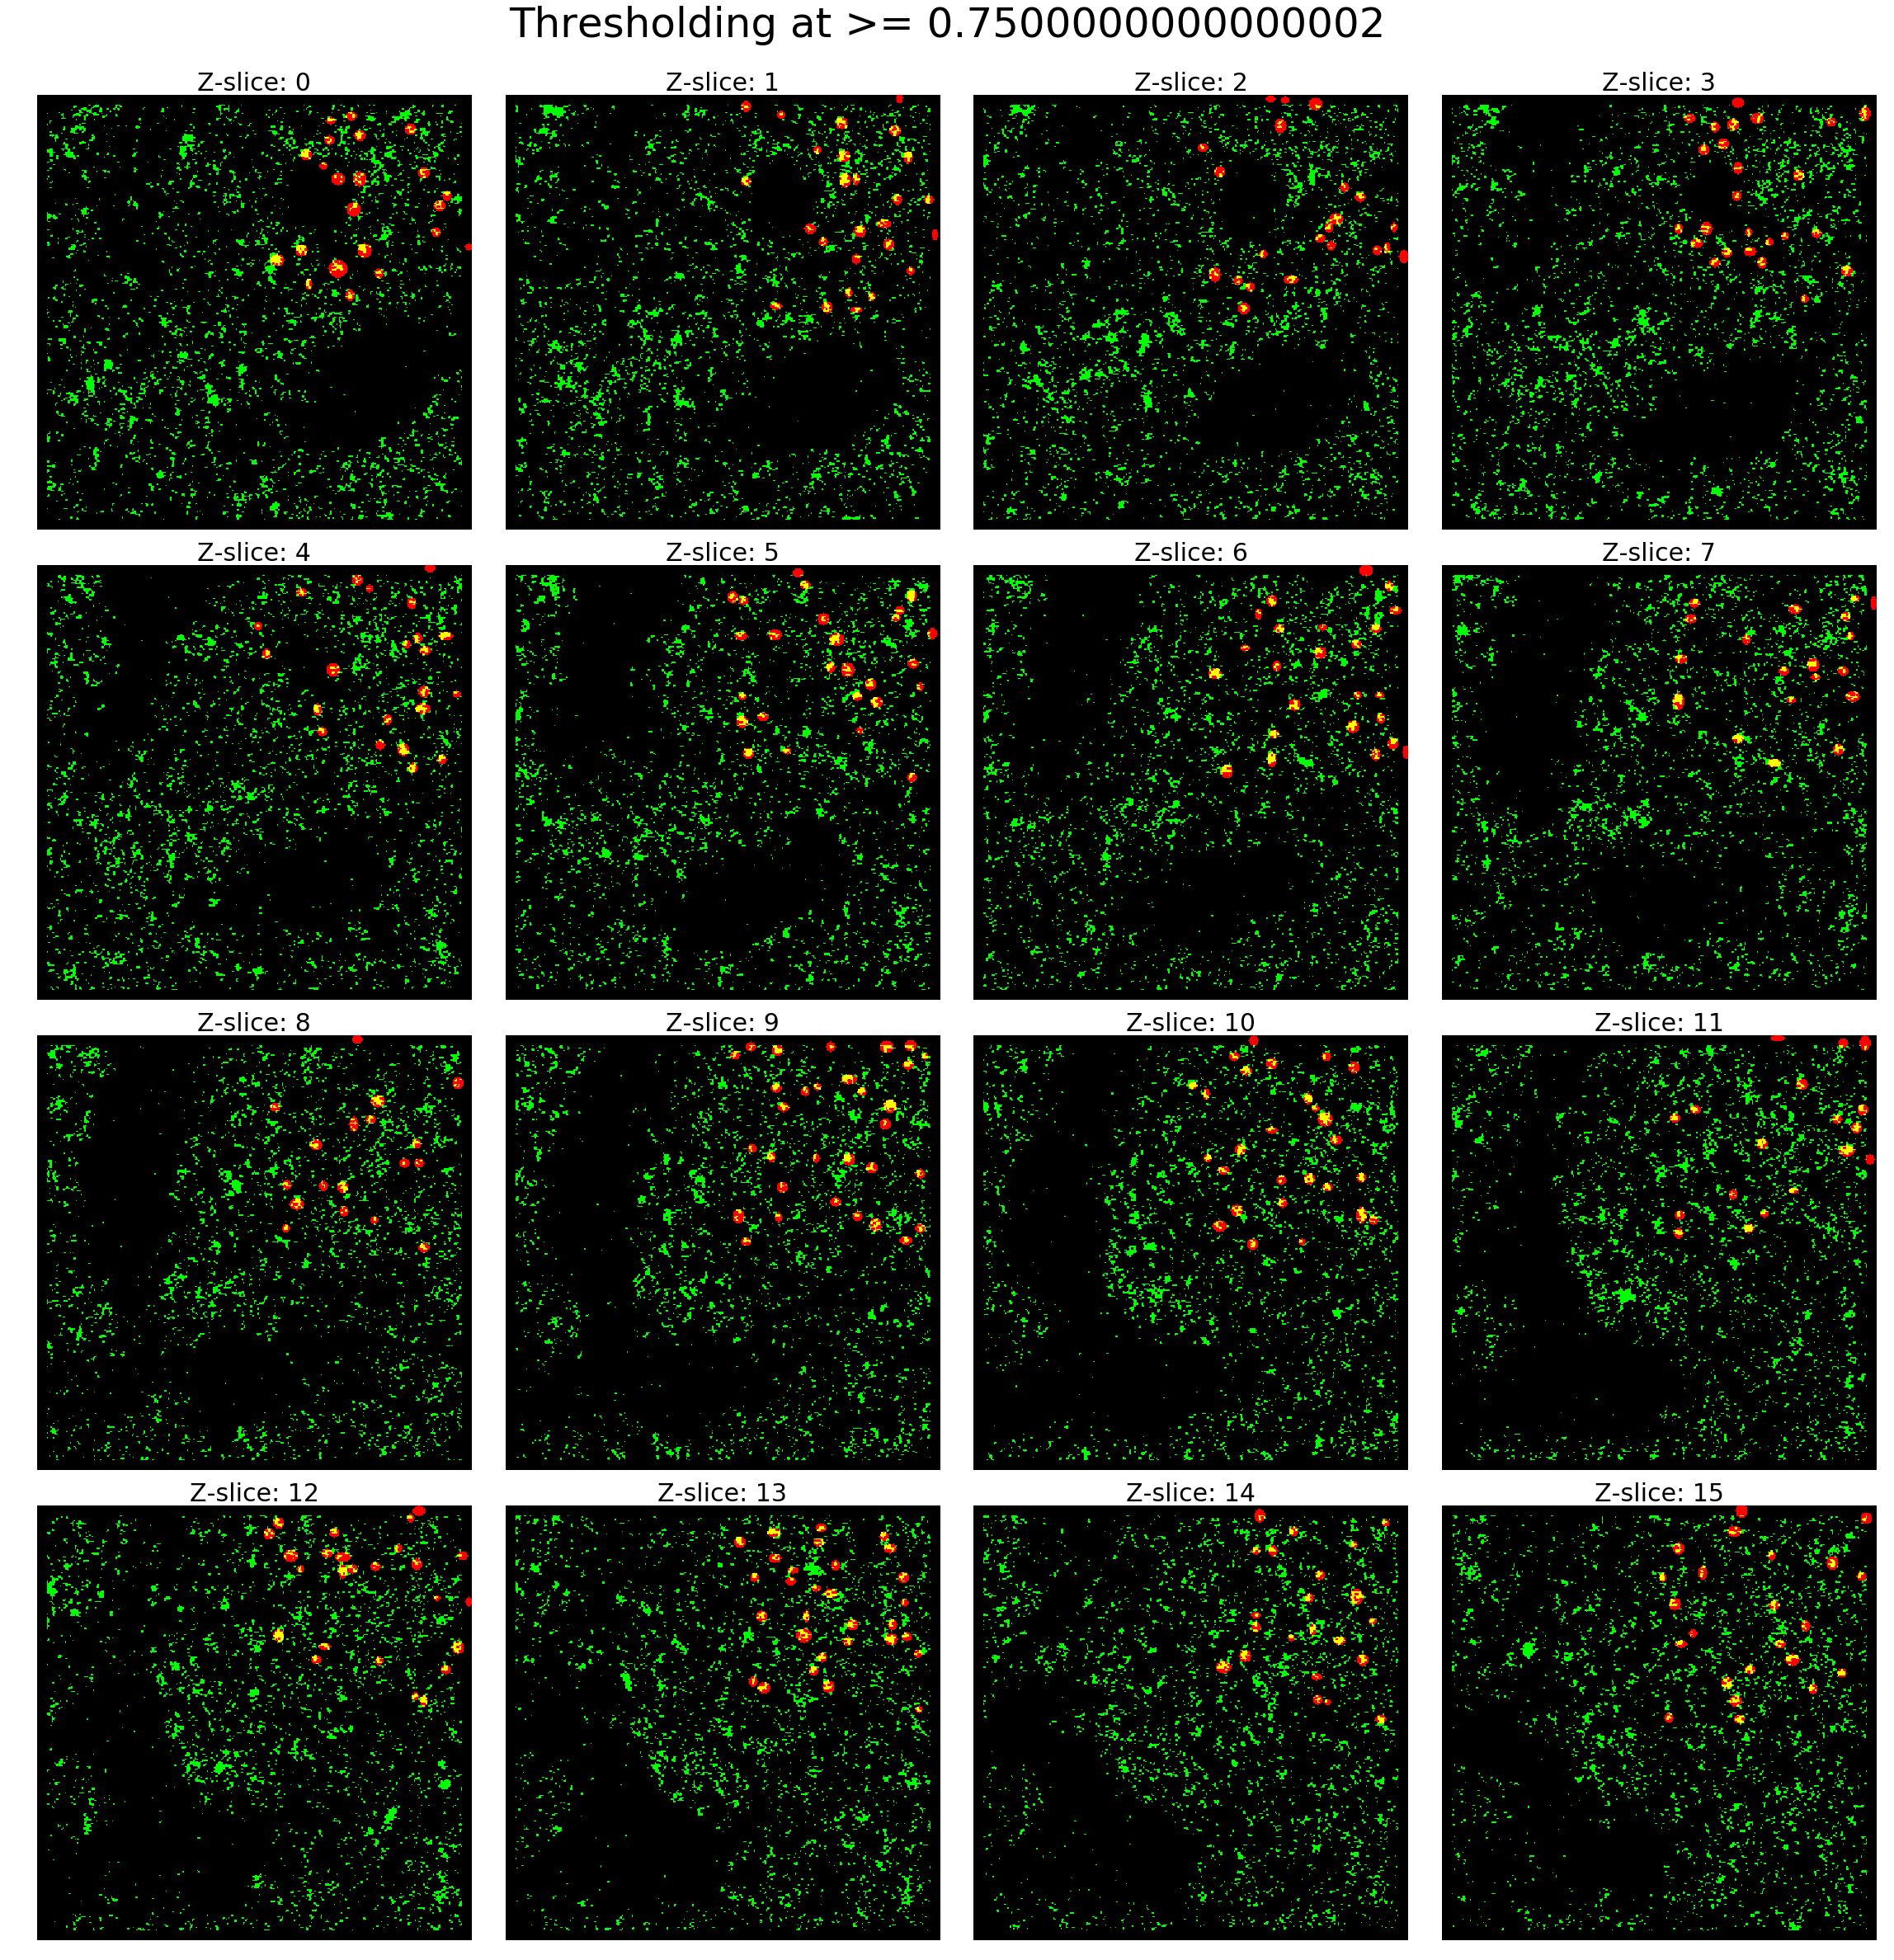

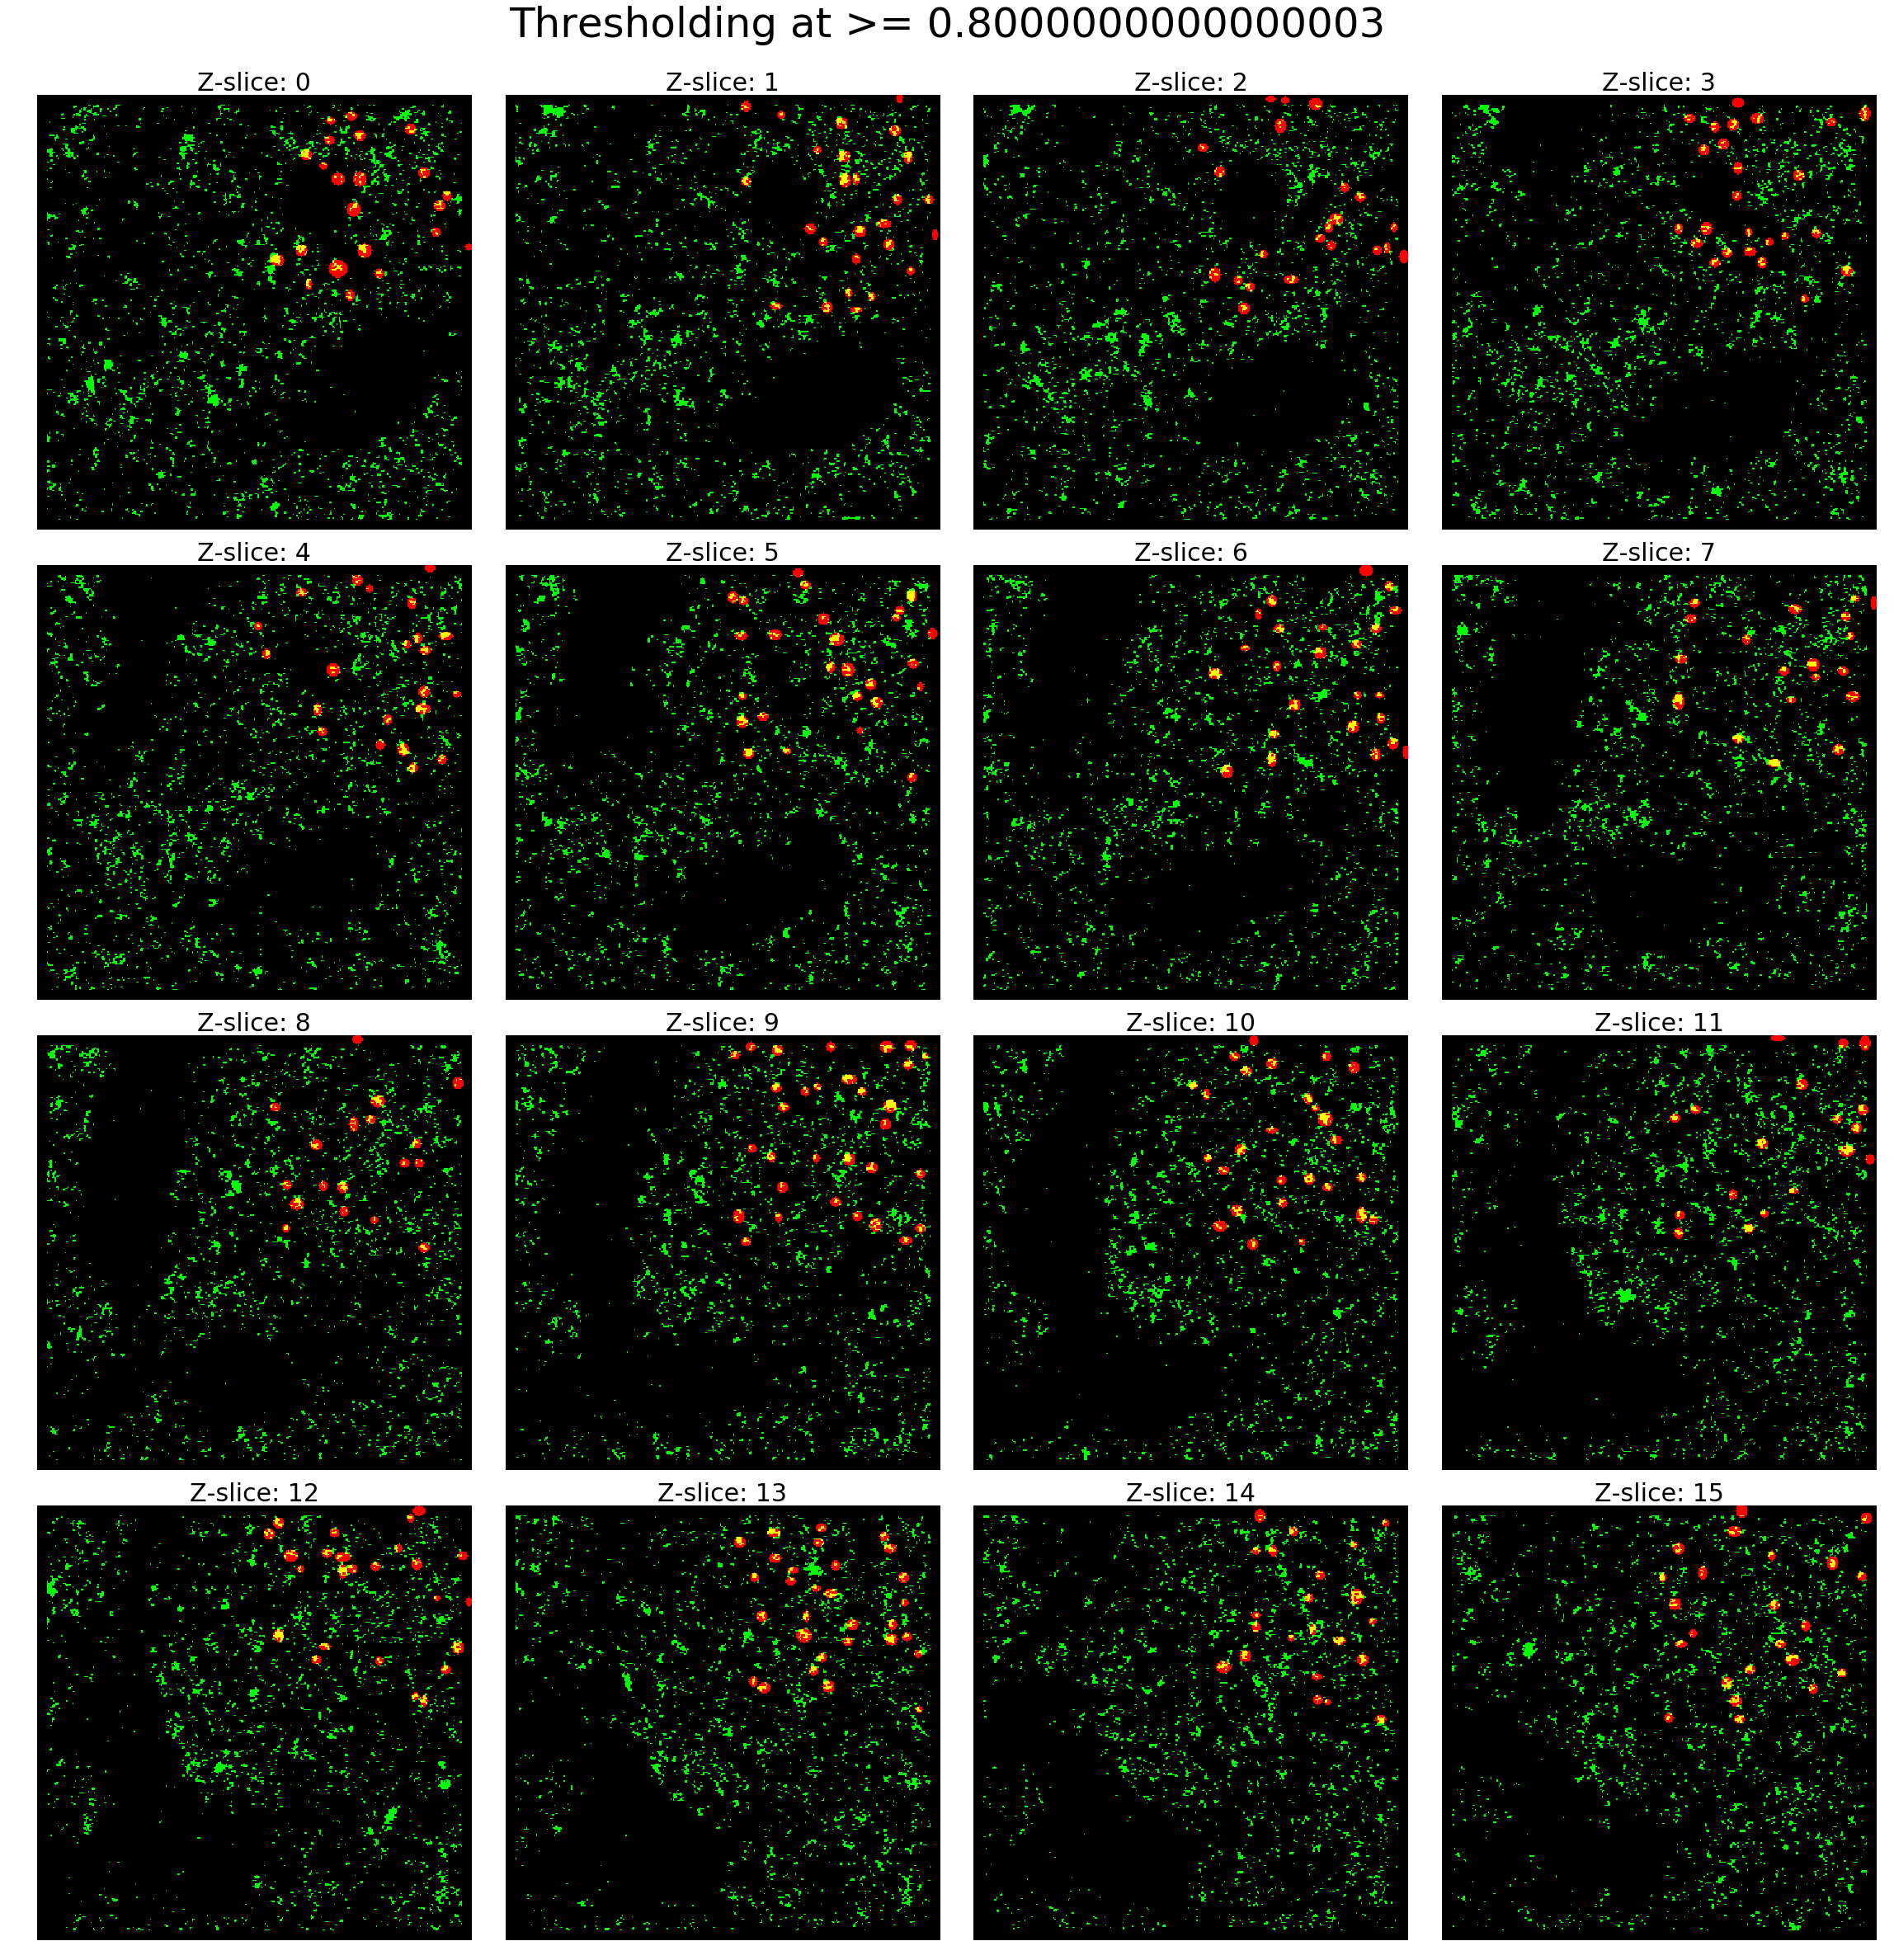

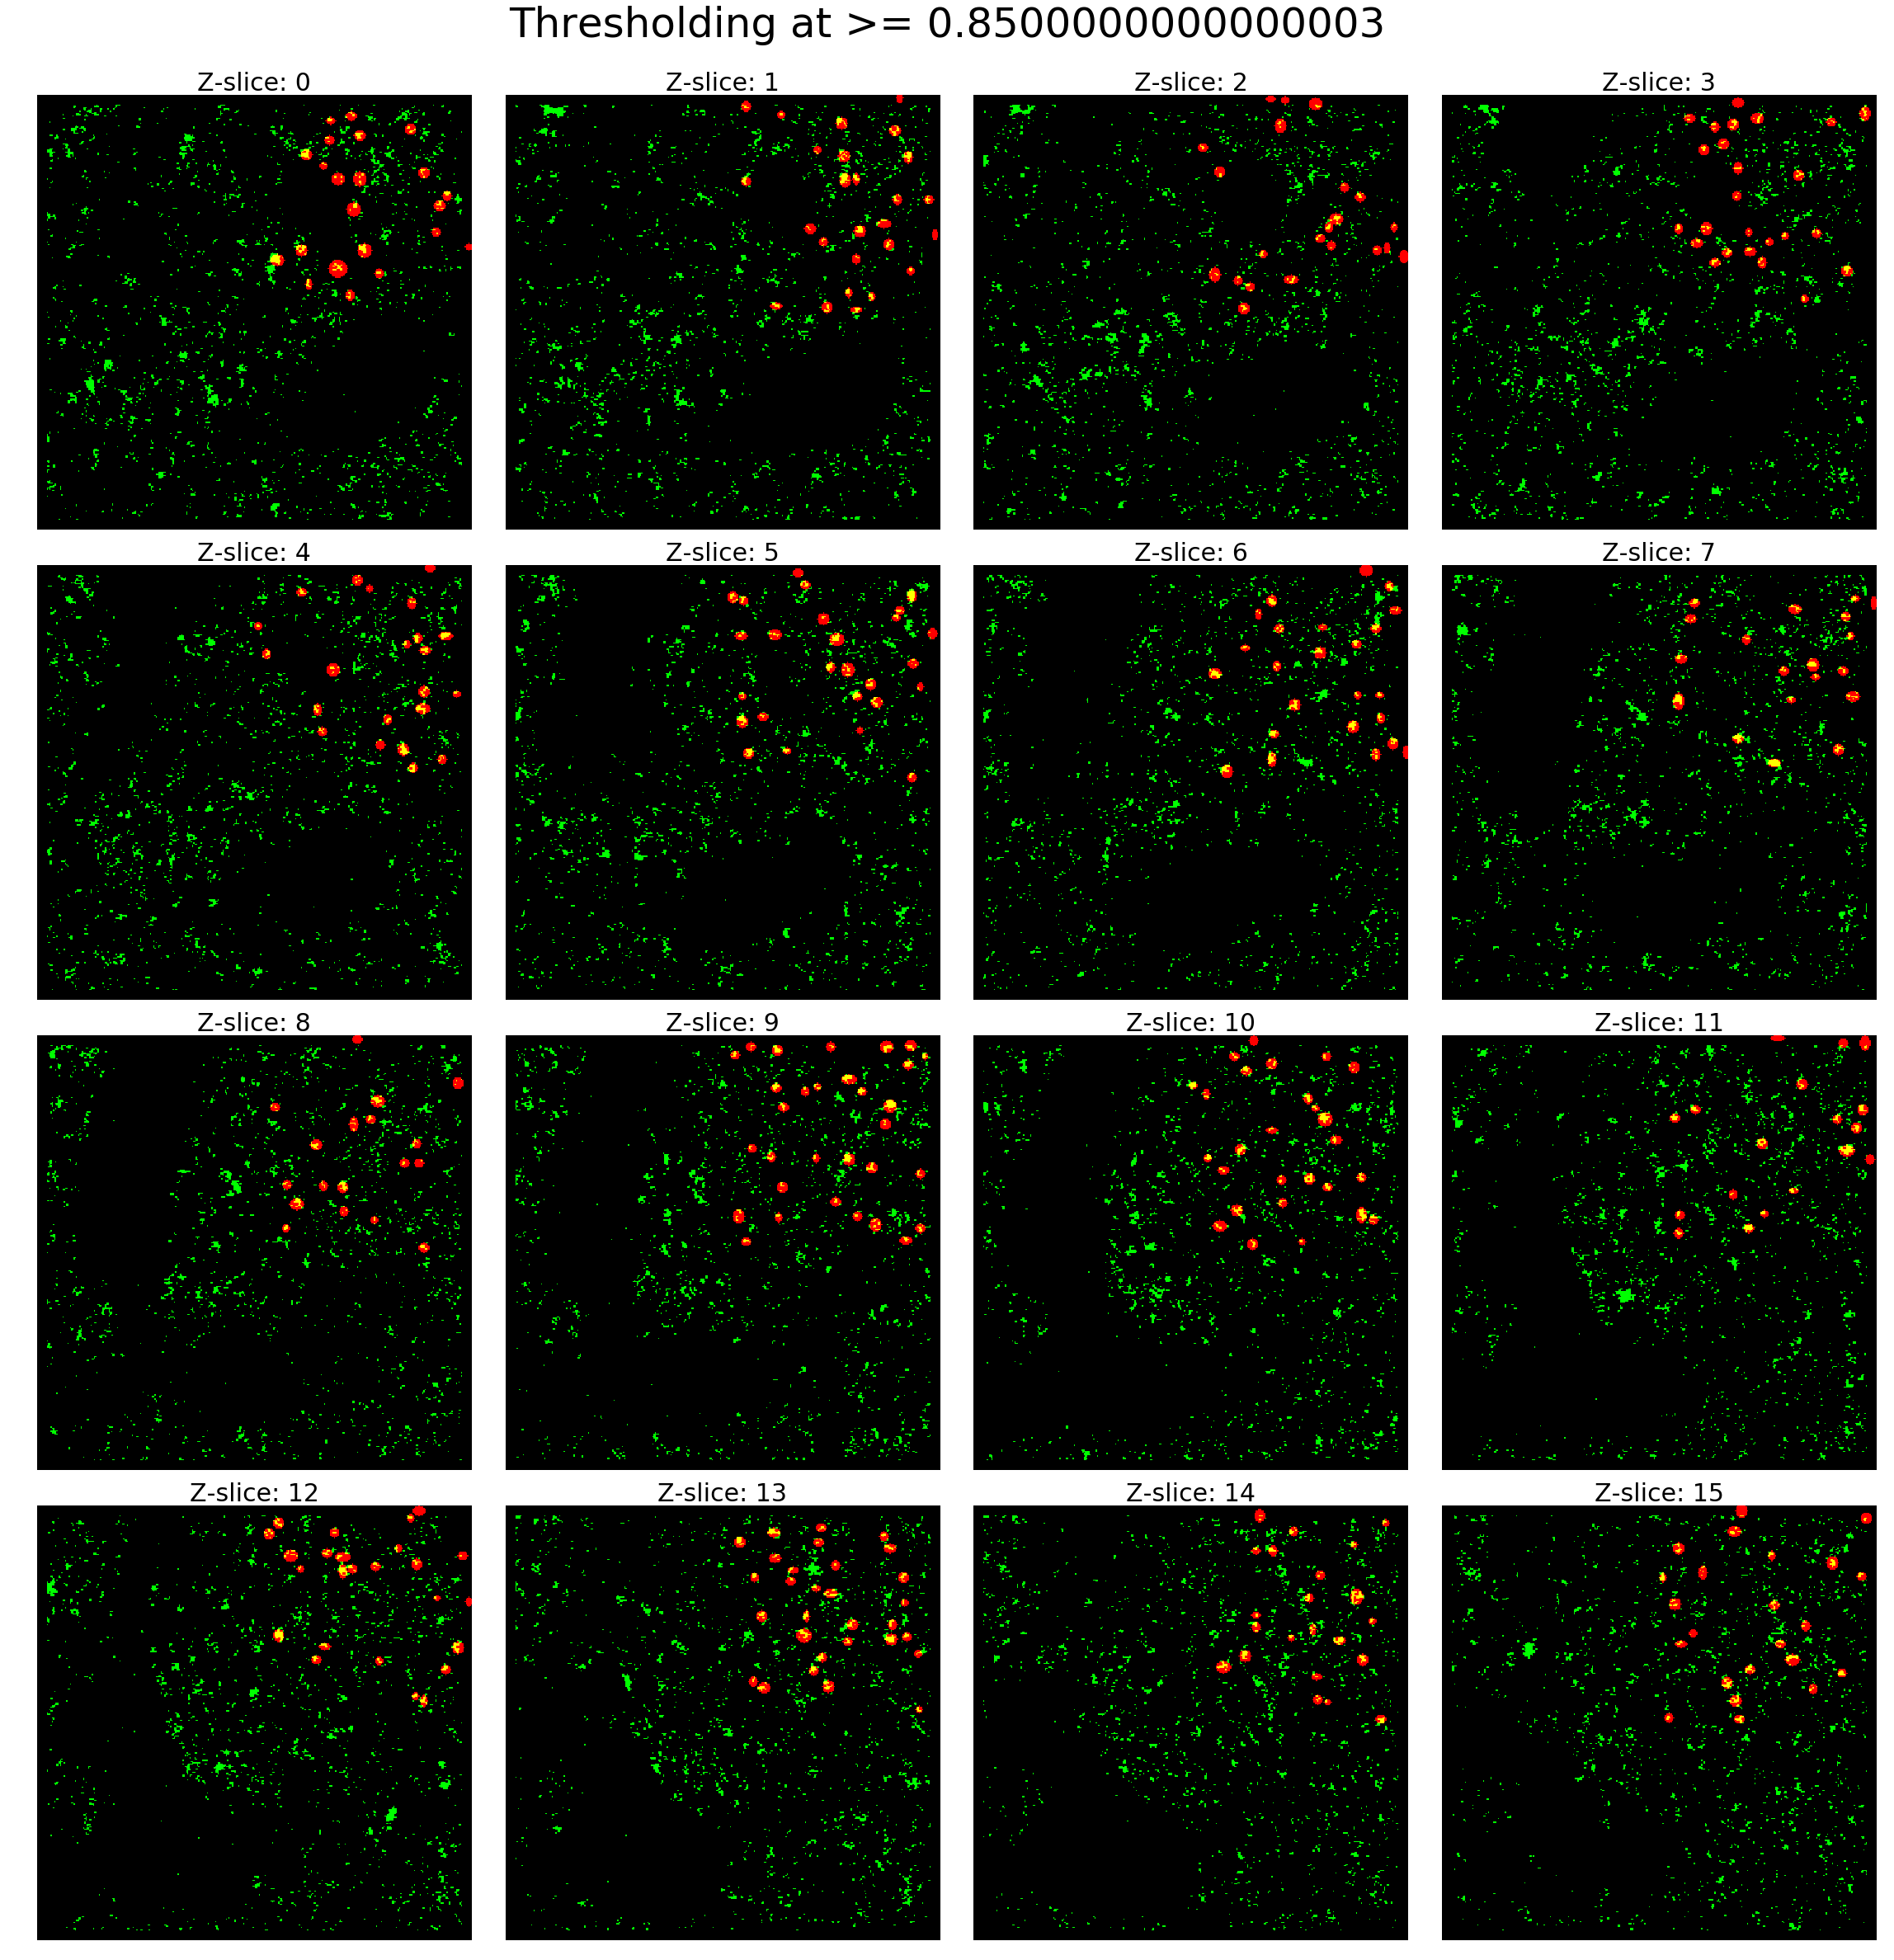

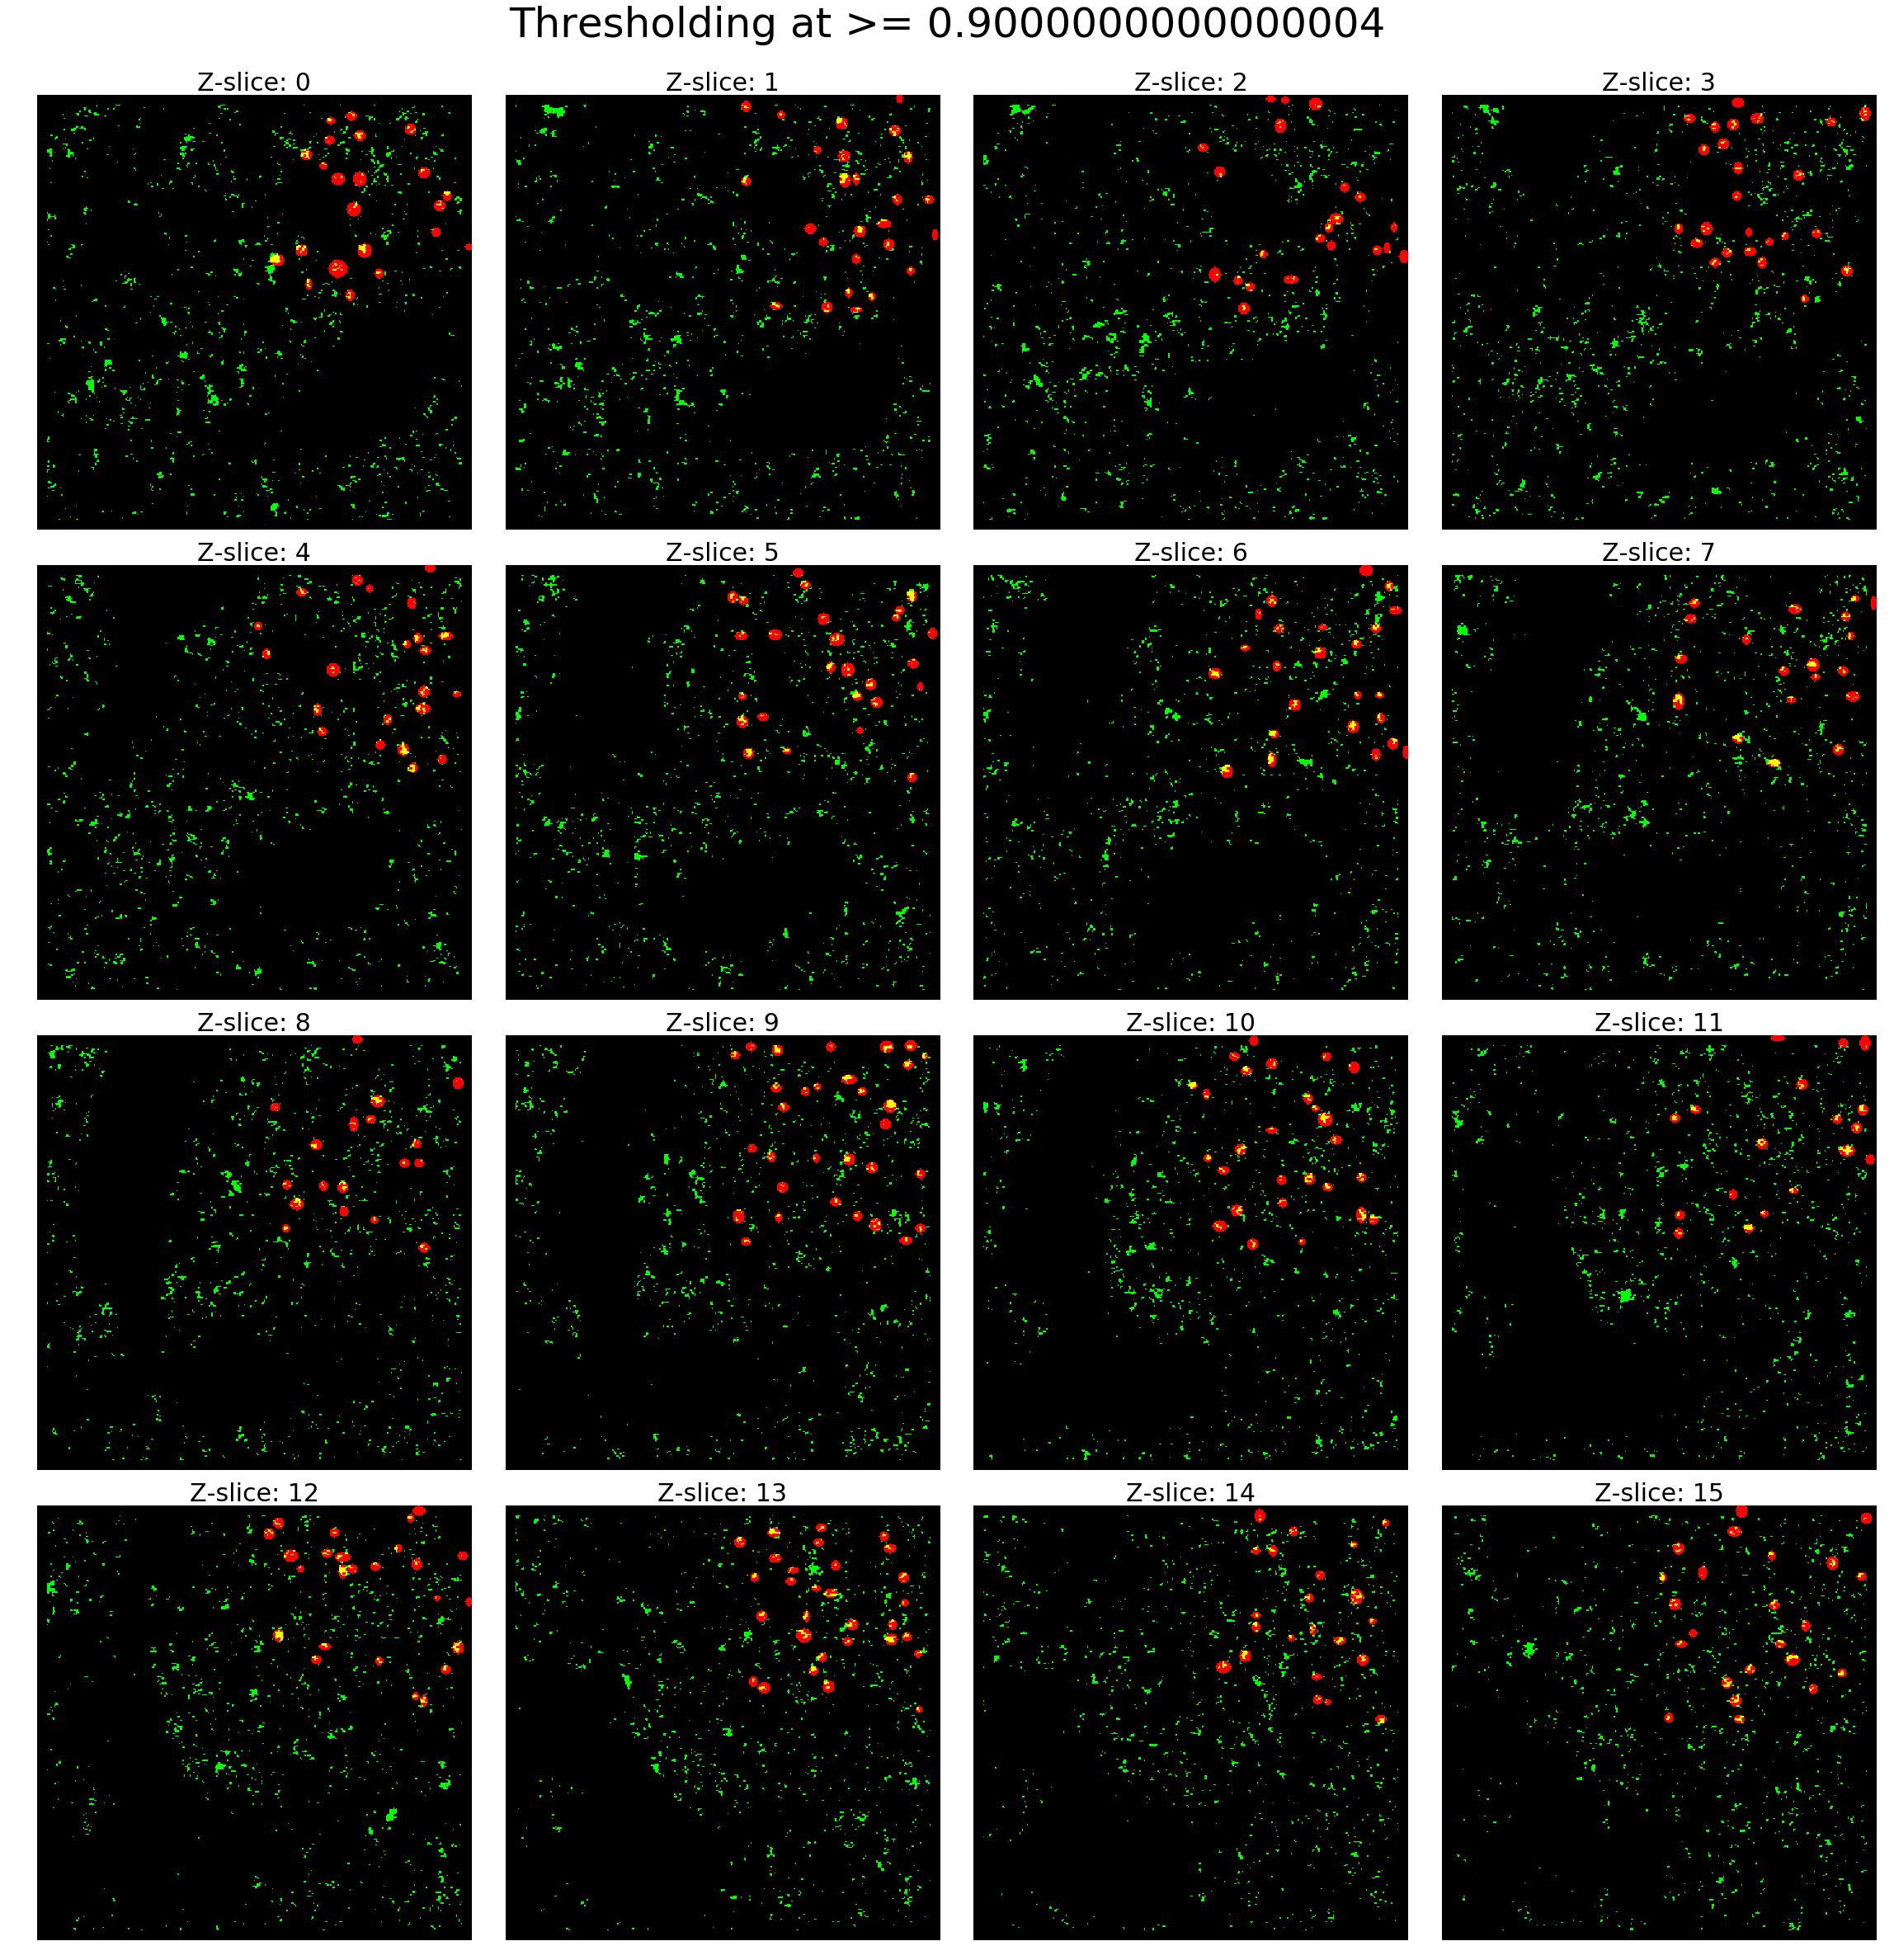

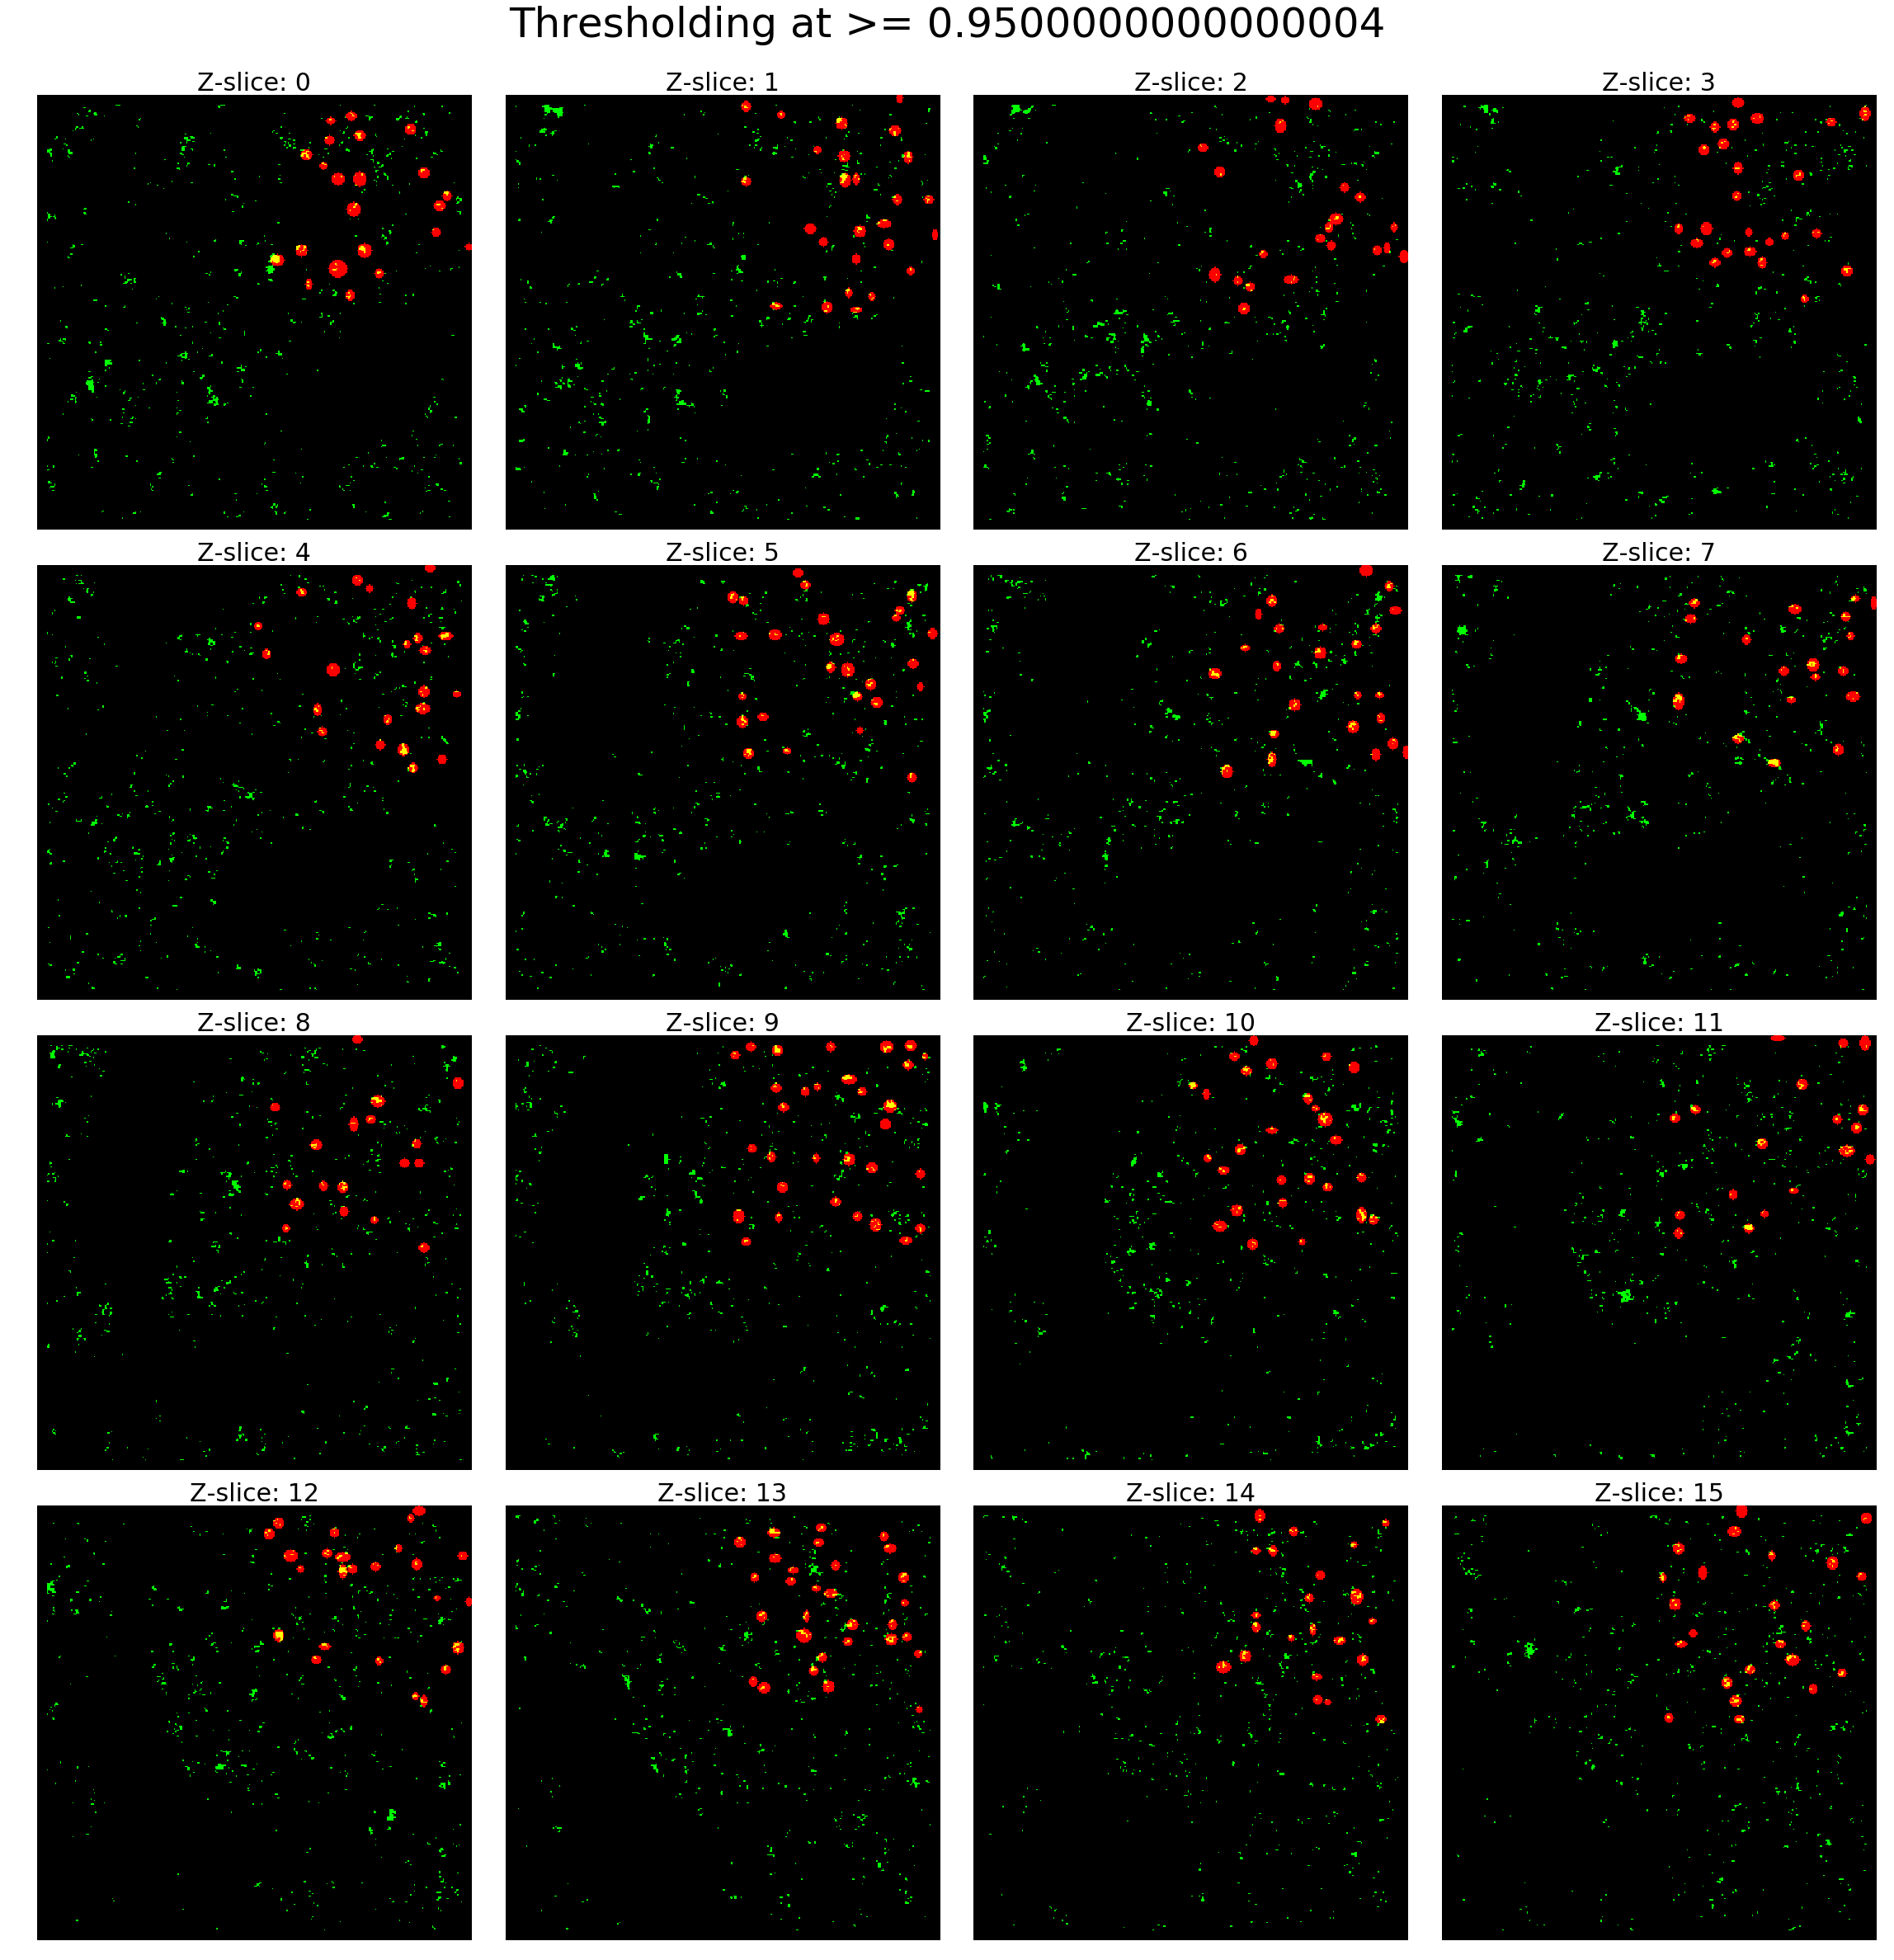

In [108]:
thresholds = np.arange(0.5, 1.0, 0.05)

for threshold in thresholds:
    labels = label(probmap_1 >= threshold)
    overlaps = compute_overlap_array(labels, annotation)
    overlay = overlay_images(annotation, labels)
    fig = plot_volume(overlay, title='Thresholding at >= {}'.format(threshold))
    display.display(fig)

## Perhaps its best to look at only the region where there are annotations

Look only at top right quandrant where annotations exist. 

#### TL;DR
Slightly higher precision, but not much change

In [78]:
z, y, x = (0, 16), (0, 179), (179, 359)

In [111]:
probmap_subsection = probmap_1[z[0]:z[1], y[0]:y[1], x[0]:x[1]]
annotation_subsection = annotation[z[0]:z[1], y[0]:y[1], x[0]:x[1]]

In [82]:
predictions = []
thresholds = np.arange(0.01, 1.01, 0.01)
for threshold in thresholds:
    labels = label(probmap_subsection >= threshold)
    predictions.append(len(np.unique(labels)))

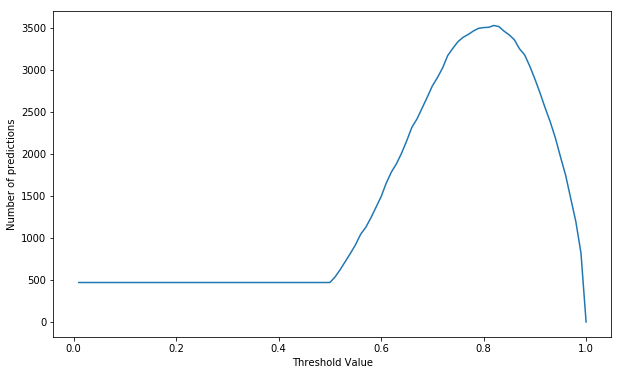

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(thresholds, predictions)
ax.set_xlabel('Threshold Value')
ax.set_ylabel('Number of predictions')
display.display(fig)

In [112]:
precisions = []
recalls = []
f1s = []
thresholds = np.arange(0.5, 1.0, 0.01)

for threshold in thresholds:
    labels = label(probmap_subsection >= threshold)
    overlaps = compute_overlap_array(labels, annotation_subsection)
    precision, recall, f1 = calculate_stats(overlaps)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

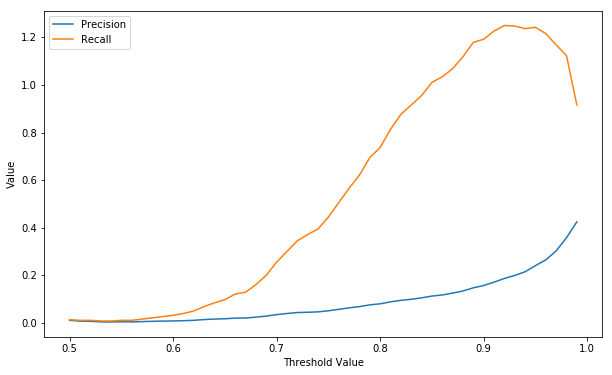

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(thresholds, precisions, label='Precision')
ax.plot(thresholds, recalls, label='Recall')
ax.set_xlabel('Threshold Value')
ax.set_ylabel('Value')
ax.legend()
display.display(fig)

## Remove small stuff prior to comparing

#### Look at the subsection. It's faster

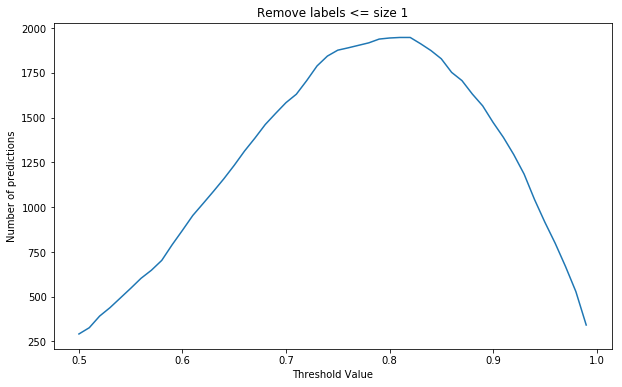

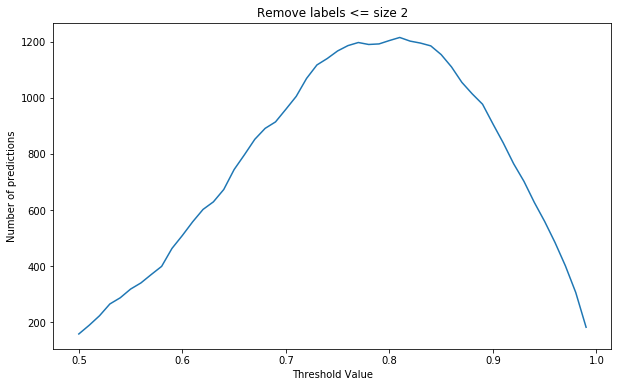

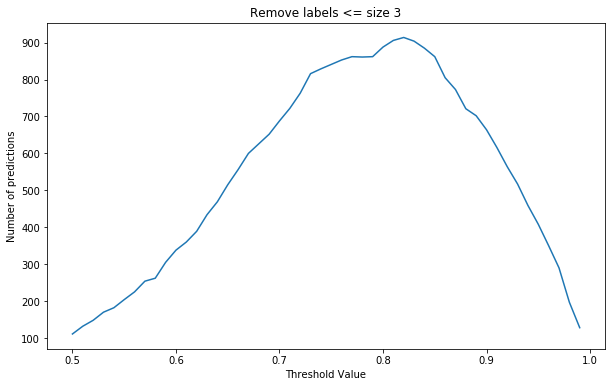

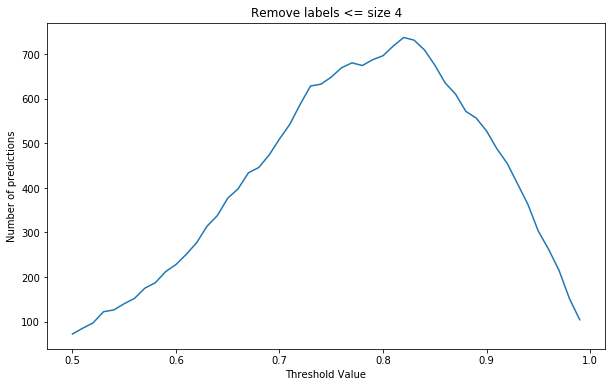

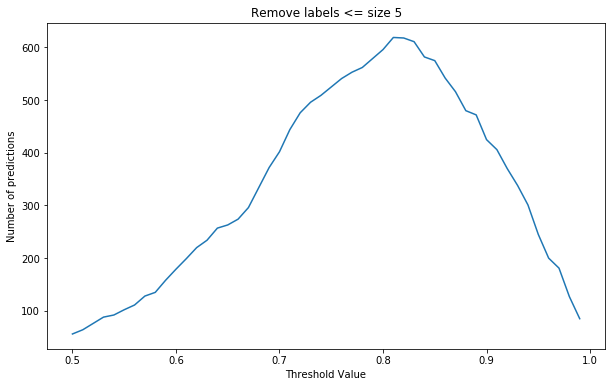

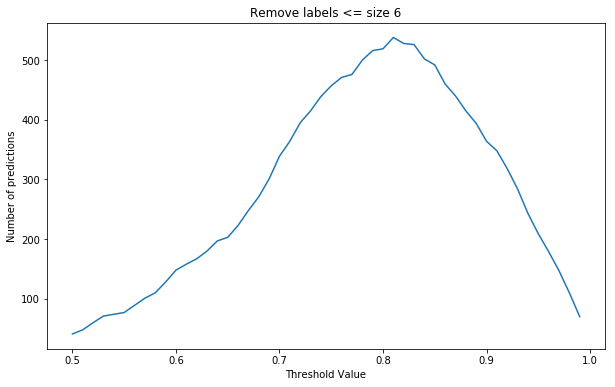

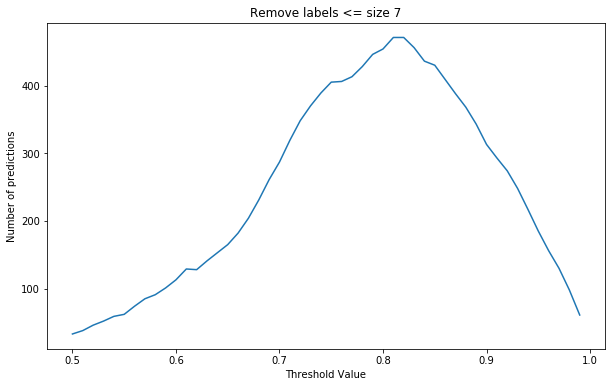

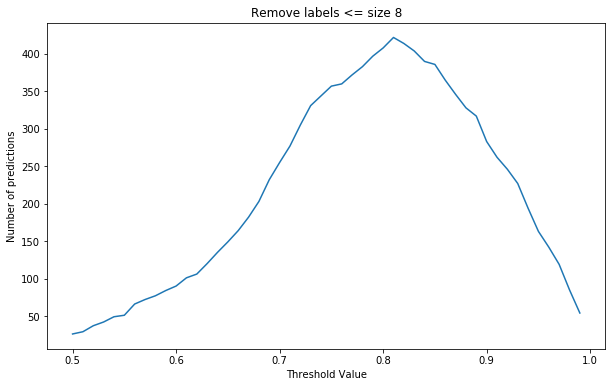

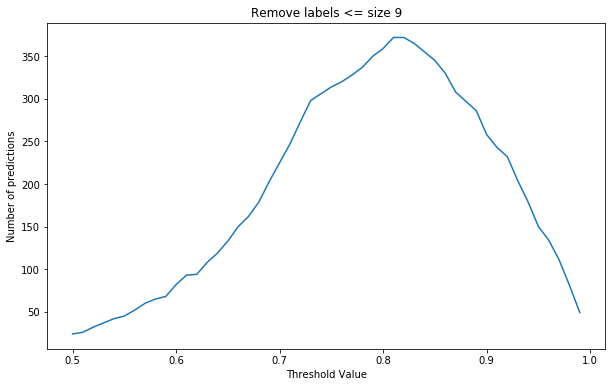

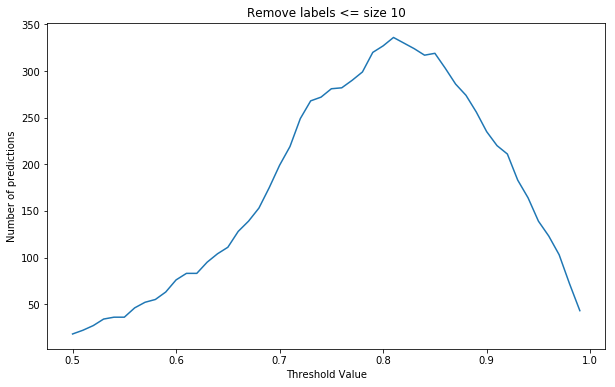

In [95]:
thresholds = np.arange(0.5, 1.0, 0.01)
min_sizes = range(1, 11, 1)

for min_size in min_sizes:
    predictions = []
    for threshold in thresholds:
        #labels = label(probmap_1 >= threshold)
        #labels = remove_labels(labels, min_size)
        labels = label(probmap_subsection >= threshold)
        labels = remove_labels(labels, min_size)
        predictions.append(len(np.unique(labels)))
        
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(thresholds, predictions)
    ax.set_xlabel('Threshold Value')
    ax.set_ylabel('Number of predictions')
    ax.set_title('Remove labels <= size {}'.format(min_size))
    display.display(fig)

## Profile precision/recall after removing labels of certain sizes

#### Again look at subsection since it runs faster

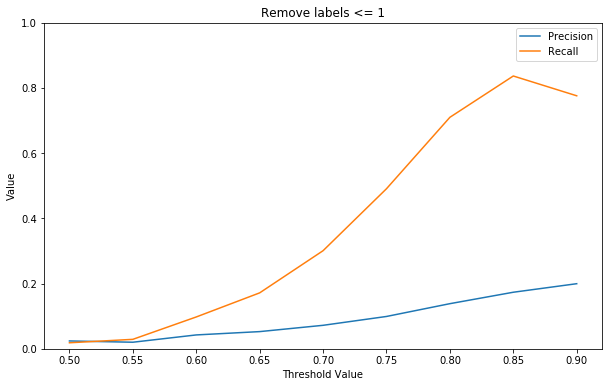

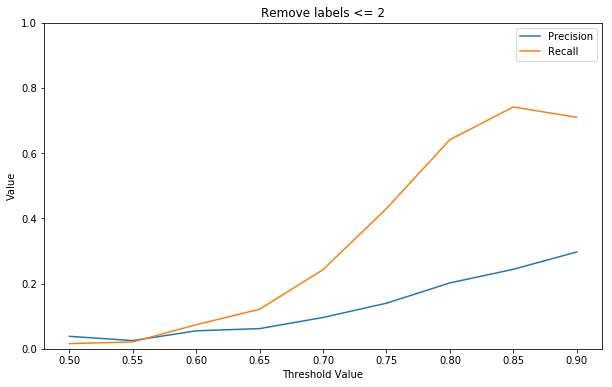

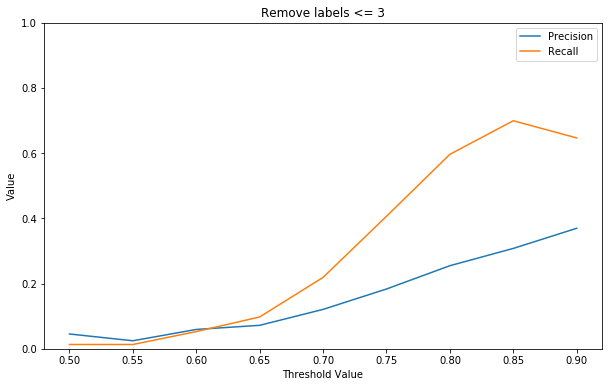

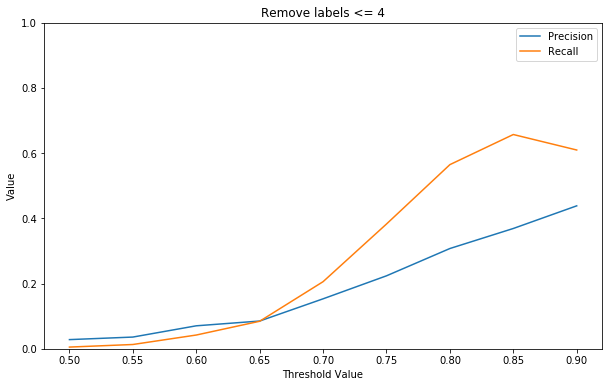

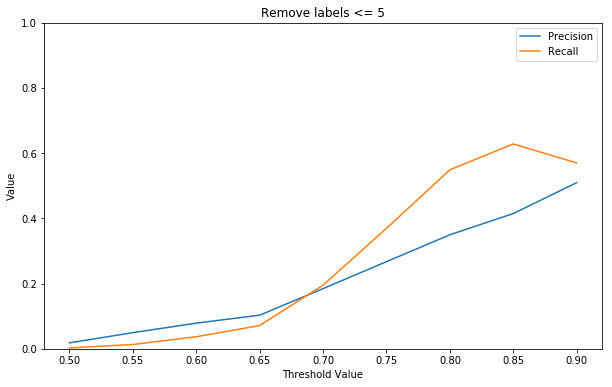

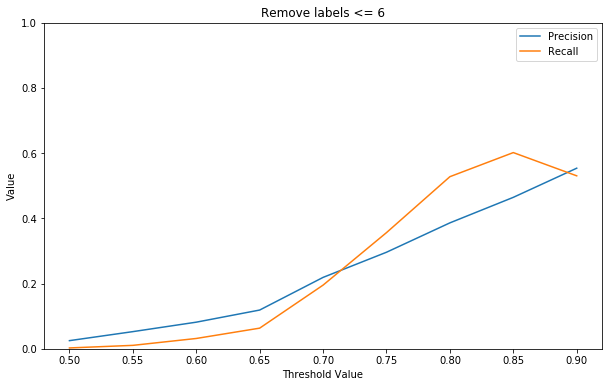

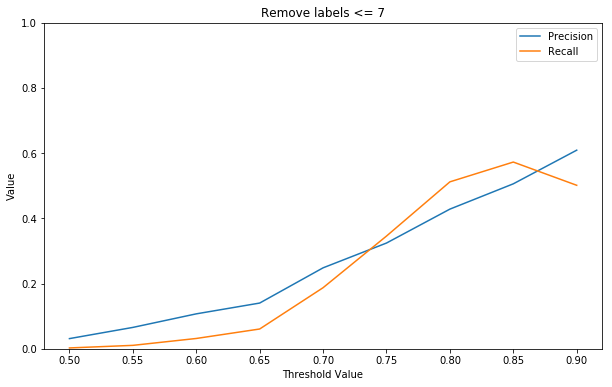

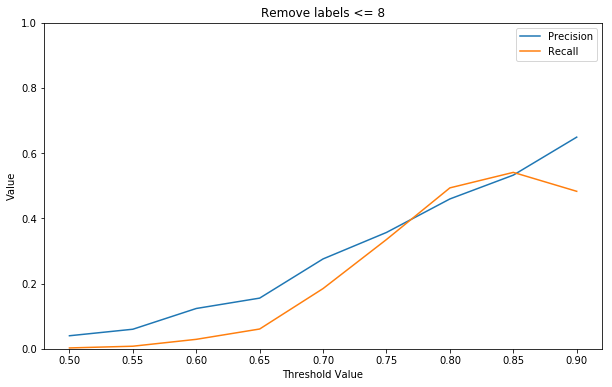

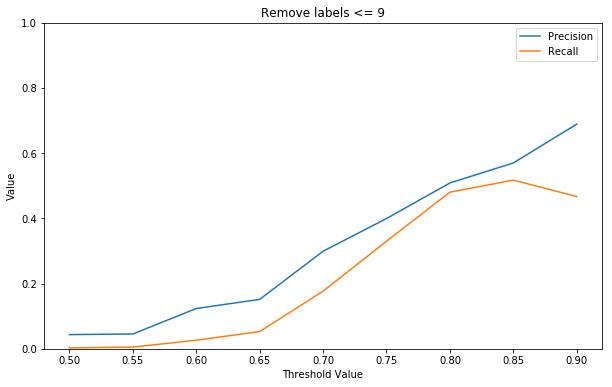

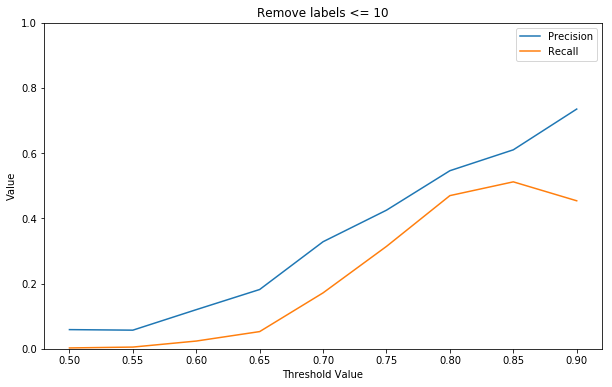

In [101]:
thresholds = np.arange(0.5, 1.0, 0.05)
min_sizes = range(1, 11, 1)
overlay_volumes = []

for min_size in min_sizes:
    precisions = []
    recalls = []
    f1s = []
    
    for threshold in thresholds:
        labels = label(probmap_subsection >= threshold)
        labels = remove_labels(labels, min_size)
        overlaps = compute_overlap_array(labels, annotation_subsection)
        precision, recall, f1 = calculate_stats(overlaps)
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        overlay_volumes.append(overlay_images(
            annotation_subsection, probmap_subsection))
        
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(thresholds[:-1], precisions[:-1], label='Precision')
    ax.plot(thresholds[:-1], recalls[:-1], label='Recall')
    ax.set_ybound(lower=0, upper=1)
    ax.set_xlabel('Threshold Value')
    ax.set_ylabel('Value')
    ax.set_title('Remove labels <= {}'.format(min_size))
    ax.legend()
    display.display(fig)

## Visual inspection of different thresholds 